#PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Lab


#Zadanie

Zaadaptuj kod z notatnika *PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Wykład* do problemu klasyfikacji liczby gwiazdek dla opinii z serwisu Yelp.
Możesz przygotować pętlę treningową albo w czystym PyTorchu, albo z wykorzystaniem biblioteki PyTorch Lightning.

* Wykorzystaj zbiór `Yelp/yelp_review_full` ([link](https://huggingface.co/datasets/Yelp/yelp_review_full)) zawierający opinie z serwisu Yelp (kolumna: `text`) i etykietę (kolumna: `label`) o wartościach $0,1,2,3,4$ określającą liczbę gwiazdek przyznaną przez użytkownika (a ściślej, liczbę gwiazdek minus jeden). Ponieważ mamy pięć klas, ostatnia warstwa liniowa w sieci neuronowej musi zwracać pięć wartości.
    * Zgodnie z dobrą praktyką z części treningowej wydziel dodatkową część walidacyjną.
    * Ogranicz rozmiar każdej części zbioru danych (treningowej, walidacyjnej i testowej). Część treningowa nie powinna zawierać więcej niż 100k elementów.
* Do ekstrakcji cech z tekstu wykorzystaj **metodę TF-IDF** (*term frequency-inverse document frequency*) opartą o podejście typu worek słów (*bag-of-words*). Zastosuj funkcję `TfidfVectorizer` z biblioteki `scikit-learn`.
* Wykorzystaj podobną architekturę sieci (perceptron wielowarstwowy z warstwą Dropout) jak w notatniku wykładowym.



## Punkty do wykonania

1.   
Napisz funkcję znajdującą i wyświetlającą $k$ elementów zbioru testowego dla których model najbardziej się myli, czyli estymuje najmniejsze prawdopodobieństwa prawdziwej klasy. Softmax jest funkcją ściśle rosnącą, więc wystarczy znaleźć elementy z najmniejszą wartością nieznormalizowanego wyjścia z sieci (logita) dla prawdziwej klasy.
2.   Zbadaj wpływ wybranych parametrów funkcji ekstrakcji cech z tekstu `TfidfVectorizer` na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami parametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym.
3.   Zbadaj wpływ wybranych hiperparametrów modelu (np. liczba warstw liniowych modelu, rozmiary warstw) i procesu uczenia (np. początkowa wartość stopy uczenia, liczba epok, typ i parametry planisty stopy uczenia, typ i parametry optymalizatora) na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami hiperparametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym. Następnie wykonaj finalną ewaluację najlepszego modelu na zbiorze testowym.


##Przygotowanie środowiska
Upewnij się, że notatnik jest uruchomiony na maszynie z GPU. Jesli GPU nie jest dostępne zmień typ maszyny (Runtime | Change runtime type) i wybierz T4 GPU.

In [1]:
!nvidia-smi

Wed Apr  9 19:04:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P5              9W /   30W |     208MiB /   4096MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Instalacja dodatkowych bibliotek: datasets (z biblioteki HuggingFace), TorchMetrics i W&B (Weights and Biases) Models.

In [2]:
!pip install -q datasets
!pip install -q torchmetrics
!pip install -q wandb


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import bibliotek.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix


print(f"Wersja biblioteki PyTorch: {torch.__version__}")

c:\Users\barte\OneDrive\Pulpit\SEMESTR 6\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wersja biblioteki PyTorch: 2.5.1+cu121


Sprawdzenie dostępności GPU.

In [4]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
import wandb

#wandb.login()

# Rozwiązanie

### Załadowanie danych

In [5]:
dataset = load_dataset("Yelp/yelp_review_full")
print(dataset)

c:\Users\barte\OneDrive\Pulpit\SEMESTR 6\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\barte\.cache\huggingface\hub\datasets--Yelp--yelp_review_full. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 386004.00 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


### Rozbicie zbioru na część treningową, walidacyjną i testową

In [6]:
split_dataset = dataset['train'].train_test_split(test_size=0.2)

full_train_dataset = split_dataset['train']
full_val_dataset = split_dataset['test']
full_test_dataset = dataset['test']

full_train_dataset, full_val_dataset, full_test_dataset

(Dataset({
     features: ['label', 'text'],
     num_rows: 520000
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 130000
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 50000
 }))

### Ogranicznie zbiorów
- 100_000 w treningowym
- 20_000 w testowym
- 10_000 w walidacyjnym

In [7]:
train_size = 100_000
val_size = 10_000
test_size = 20_000

train_dataset = full_train_dataset.shuffle().select(range(train_size))
val_dataset   = full_val_dataset.shuffle().select(range(val_size))
test_dataset  = full_test_dataset.shuffle().select(range(test_size))

print(f"Liczba próbek w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_dataset)}")
print(f"Liczba próbek w zbiorze testowym: {len(test_dataset)}")

Liczba próbek w zbiorze treningowym: 100000
Liczba próbek w zbiorze walidacyjnym: 10000
Liczba próbek w zbiorze testowym: 20000


### Sprawdzenie ilości klas w każdym ze zbiorów

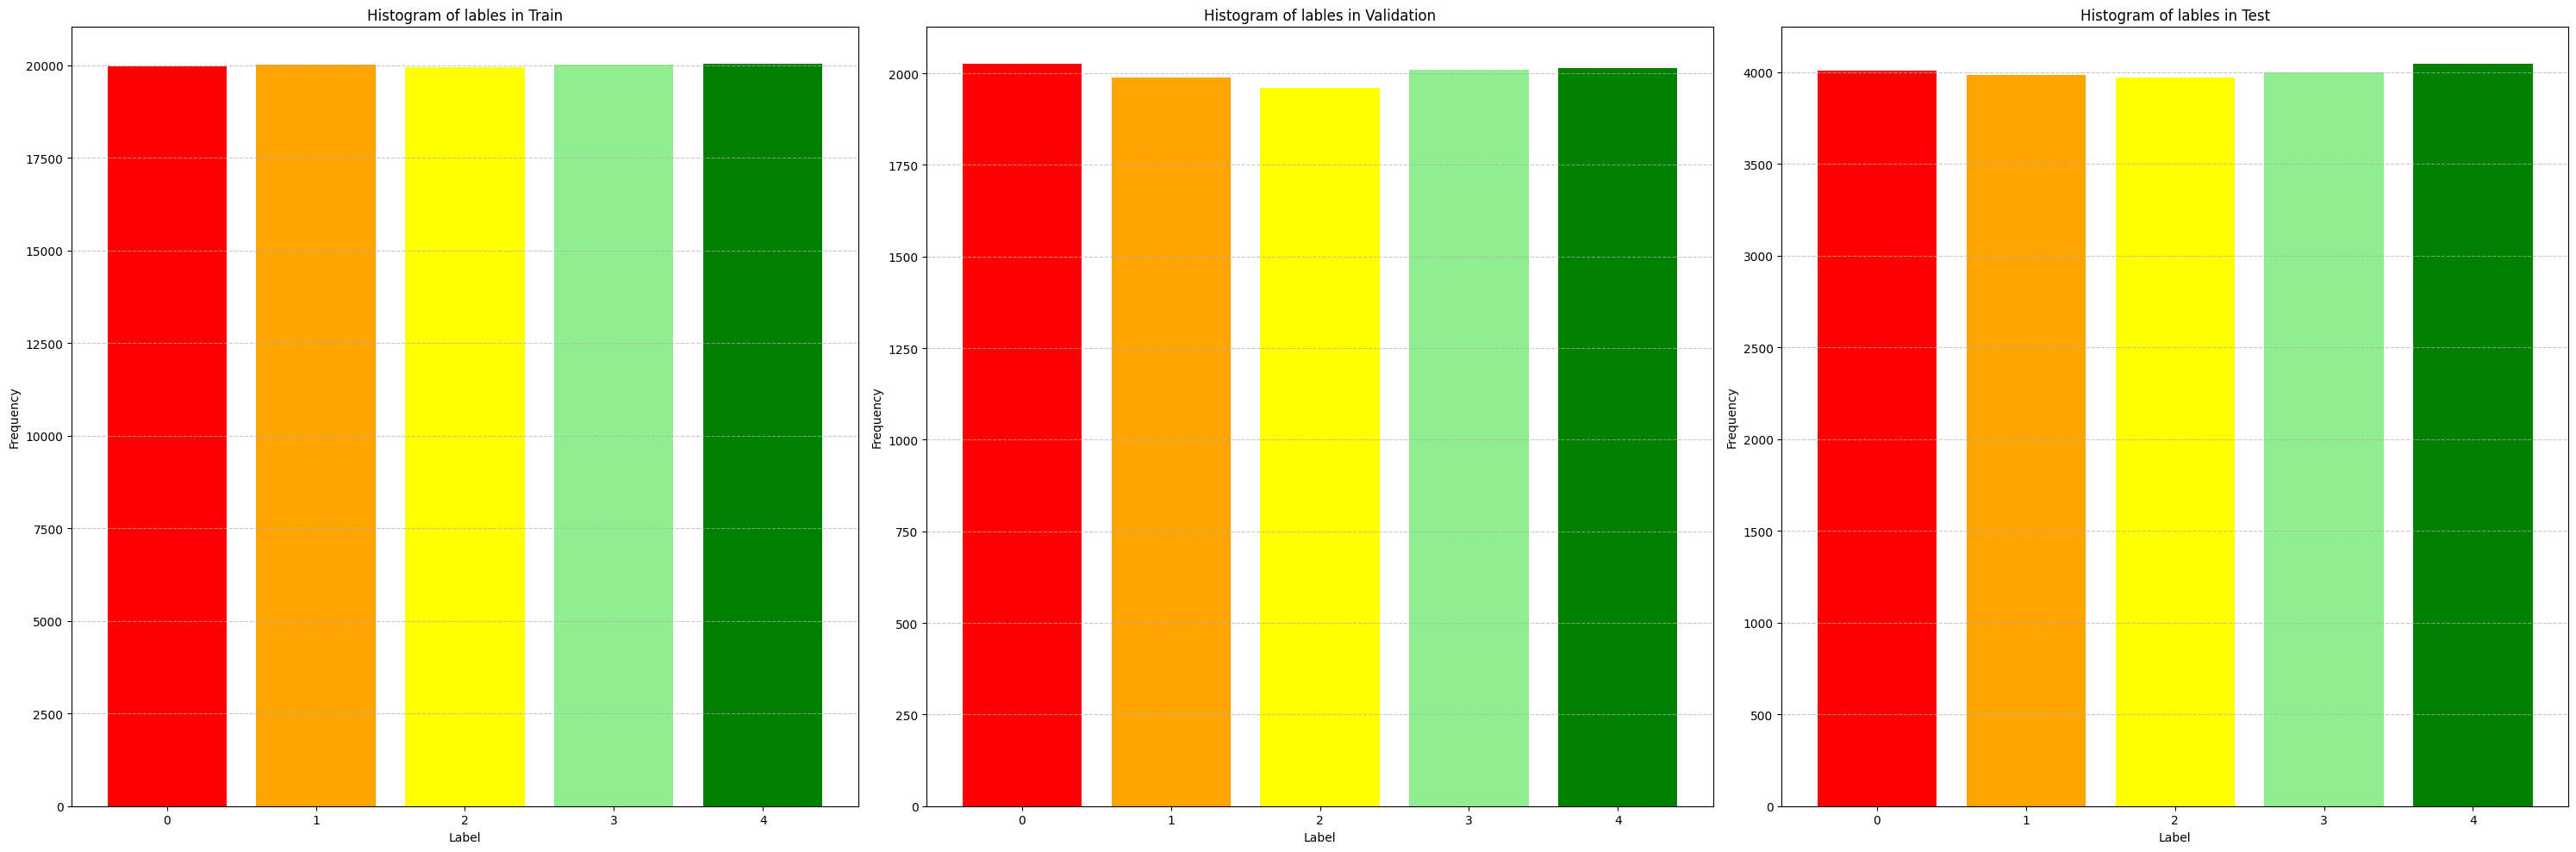

In [8]:
def chek_unique_labels_count_in_dataset(dataset_type, dataset, ax):

    unique_labels, counts = np.unique(dataset['label'], return_counts=True)

    ax.bar(unique_labels, counts, color=["red", "orange", "yellow", "lightgreen", "green"])
    ax.set_title(f"Histogram of lables in {dataset_type}")
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(unique_labels)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

chek_unique_labels_count_in_dataset("Train", train_dataset, axes[0])
chek_unique_labels_count_in_dataset("Validation", val_dataset, axes[1])
chek_unique_labels_count_in_dataset("Test", test_dataset, axes[2])

plt.tight_layout()
plt.show()

### TFIDFVectorizer

In [ ]:
first_vectorizer = TfidfVectorizer(
    max_features=10_000,
    lowercase=True,
    analyzer='word',
    ngram_range=(1,1),
    stop_words='english')

first_vectorizer


TfidfVectorizer(max_features=10000, stop_words='english')

### Funkcje pomocnicze

In [10]:
def create_tfidf_features(vectorizer, dataset_train, dataset_val, dataset_test):
  train_tfidf = vectorizer.fit_transform(dataset_train['text'])

  val_tfidf = vectorizer.transform(dataset_val['text'])
  test_tfidf = vectorizer.transform(dataset_test['text'])

  return train_tfidf, val_tfidf, test_tfidf

def create_tensor_dataset(tfidf_features, labels):
    dense_features = tfidf_features.astype(np.float32).todense()

    dataset = TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )
    return dataset

def create_dataloaders(dataset, batchsize, shuffle):
  return DataLoader(dataset, batch_size=batchsize, shuffle=shuffle)

def train(device, model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, verbose: bool=True):

    # MEtrics
    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    # Run all epochs
    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()


            for X_batch, target in tqdm(loaders[phase]):
                X_batch, target = X_batch.to(device), target.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):

                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    # if correct phase than train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            # Batch metrics
            acc = metric_acc.compute()
            mean_loss = metric_loss.compute()
            current_lr = lr_scheduler.get_last_lr()[0]
            if verbose:
              print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")
            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": acc,
                f"{phase}/lr": current_lr,
            }

            # Clean metrics
            metric_loss.reset()
            metric_acc.reset()

        lr_scheduler.step()

def evaluate_model(device, model: nn.Module, test_dataloader: DataLoader):
  preds_l = []
  targets_l = []

  for xb, yb in tqdm(test_dataloader):
    xb, yb = xb.to(device), yb.to(device)

    with torch.inference_mode():
      logits = model(xb)

      _, preds = torch.max(logits, dim=-1)
      preds_l.extend(preds.cpu().numpy())
      targets_l.extend(yb.cpu().numpy())

  preds = np.array(preds_l)
  targets = np.array(targets_l)

  target_names = ['0', '1', '2', '3', '4']
  report = classification_report(targets, preds, target_names = target_names)

  accuracy = (preds==targets).sum()/len(preds)

  return report, accuracy



### Pierwszy prosty model

In [11]:
class SimpleNet(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(16, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

### Pierwszy prosty model - trening i ewaluacja

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

train_idf, val_idf, test_idf = create_tfidf_features(first_vectorizer, train_dataset, val_dataset, test_dataset)

tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

train_loader = create_dataloaders(tensor_train_dataset, 256, True)
val_loader = create_dataloaders(tensor_val_dataset, 256, False)
test_dataloader = create_dataloaders(tensor_test_dataset, 256, False)

dict_loaders = {'train' : train_loader,
                'val' : val_loader
                }

model = SimpleNet(10_000, n_classes=5).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

train(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 20)


report, accuracy = evaluate_model(device, model, test_dataloader)

print(f"Accuracy of the model is{accuracy}")
print(report)

100%|██████████| 391/391 [00:04<00:00, 78.76it/s]


(Epoch 1/[train]) Loss:	1.598   Accuracy: 0.202   lr: 0.0001


100%|██████████| 40/40 [00:00<00:00, 120.01it/s]


(Epoch 1/[val]) Loss:	1.564   Accuracy: 0.201   lr: 0.0001


100%|██████████| 391/391 [00:04<00:00, 96.81it/s]


(Epoch 2/[train]) Loss:	1.473   Accuracy: 0.338   lr: 9.94459753267812e-05


100%|██████████| 40/40 [00:00<00:00, 106.33it/s]


(Epoch 2/[val]) Loss:	1.371   Accuracy: 0.442   lr: 9.94459753267812e-05


100%|██████████| 391/391 [00:04<00:00, 97.60it/s] 


(Epoch 3/[train]) Loss:	1.274   Accuracy: 0.479   lr: 9.779754323328192e-05


100%|██████████| 40/40 [00:00<00:00, 127.17it/s]


(Epoch 3/[val]) Loss:	1.192   Accuracy: 0.517   lr: 9.779754323328192e-05


100%|██████████| 391/391 [00:03<00:00, 103.23it/s]


(Epoch 4/[train]) Loss:	1.135   Accuracy: 0.527   lr: 9.509529358847657e-05


100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


(Epoch 4/[val]) Loss:	1.088   Accuracy: 0.551   lr: 9.509529358847657e-05


100%|██████████| 391/391 [00:04<00:00, 95.83it/s]


(Epoch 5/[train]) Loss:	1.060   Accuracy: 0.547   lr: 9.140576474687265e-05


100%|██████████| 40/40 [00:00<00:00, 96.02it/s]


(Epoch 5/[val]) Loss:	1.035   Accuracy: 0.563   lr: 9.140576474687265e-05


100%|██████████| 391/391 [00:03<00:00, 100.17it/s]


(Epoch 6/[train]) Loss:	1.017   Accuracy: 0.559   lr: 8.681980515339465e-05


100%|██████████| 40/40 [00:00<00:00, 120.26it/s]


(Epoch 6/[val]) Loss:	1.006   Accuracy: 0.567   lr: 8.681980515339465e-05


100%|██████████| 391/391 [00:03<00:00, 98.07it/s]


(Epoch 7/[train]) Loss:	0.991   Accuracy: 0.567   lr: 8.145033635316131e-05


100%|██████████| 40/40 [00:00<00:00, 120.38it/s]


(Epoch 7/[val]) Loss:	0.991   Accuracy: 0.574   lr: 8.145033635316131e-05


100%|██████████| 391/391 [00:04<00:00, 86.85it/s] 


(Epoch 8/[train]) Loss:	0.973   Accuracy: 0.574   lr: 7.542957248827961e-05


100%|██████████| 40/40 [00:00<00:00, 129.85it/s]


(Epoch 8/[val]) Loss:	0.982   Accuracy: 0.574   lr: 7.542957248827961e-05


100%|██████████| 391/391 [00:03<00:00, 107.44it/s]


(Epoch 9/[train]) Loss:	0.960   Accuracy: 0.580   lr: 6.890576474687264e-05


100%|██████████| 40/40 [00:00<00:00, 121.19it/s]


(Epoch 9/[val]) Loss:	0.977   Accuracy: 0.576   lr: 6.890576474687264e-05


100%|██████████| 391/391 [00:03<00:00, 102.33it/s]


(Epoch 10/[train]) Loss:	0.950   Accuracy: 0.585   lr: 6.20395509268104e-05


100%|██████████| 40/40 [00:00<00:00, 121.95it/s]


(Epoch 10/[val]) Loss:	0.973   Accuracy: 0.577   lr: 6.20395509268104e-05


100%|██████████| 391/391 [00:04<00:00, 92.33it/s] 


(Epoch 11/[train]) Loss:	0.941   Accuracy: 0.589   lr: 5.500000000000001e-05


100%|██████████| 40/40 [00:00<00:00, 128.90it/s]


(Epoch 11/[val]) Loss:	0.971   Accuracy: 0.577   lr: 5.500000000000001e-05


100%|██████████| 391/391 [00:03<00:00, 104.85it/s]


(Epoch 12/[train]) Loss:	0.937   Accuracy: 0.591   lr: 4.7960449073189627e-05


100%|██████████| 40/40 [00:00<00:00, 131.18it/s]


(Epoch 12/[val]) Loss:	0.970   Accuracy: 0.577   lr: 4.7960449073189627e-05


100%|██████████| 391/391 [00:03<00:00, 103.92it/s]


(Epoch 13/[train]) Loss:	0.934   Accuracy: 0.592   lr: 4.109423525312737e-05


100%|██████████| 40/40 [00:00<00:00, 124.80it/s]


(Epoch 13/[val]) Loss:	0.970   Accuracy: 0.577   lr: 4.109423525312737e-05


100%|██████████| 391/391 [00:04<00:00, 96.84it/s] 


(Epoch 14/[train]) Loss:	0.928   Accuracy: 0.596   lr: 3.45704275117204e-05


100%|██████████| 40/40 [00:00<00:00, 61.28it/s]


(Epoch 14/[val]) Loss:	0.969   Accuracy: 0.578   lr: 3.45704275117204e-05


100%|██████████| 391/391 [00:03<00:00, 102.50it/s]


(Epoch 15/[train]) Loss:	0.925   Accuracy: 0.597   lr: 2.8549663646838717e-05


100%|██████████| 40/40 [00:00<00:00, 127.29it/s]


(Epoch 15/[val]) Loss:	0.969   Accuracy: 0.578   lr: 2.8549663646838717e-05


100%|██████████| 391/391 [00:03<00:00, 101.27it/s]


(Epoch 16/[train]) Loss:	0.922   Accuracy: 0.597   lr: 2.3180194846605367e-05


100%|██████████| 40/40 [00:00<00:00, 97.66it/s]


(Epoch 16/[val]) Loss:	0.968   Accuracy: 0.580   lr: 2.3180194846605367e-05


100%|██████████| 391/391 [00:04<00:00, 90.59it/s]


(Epoch 17/[train]) Loss:	0.920   Accuracy: 0.598   lr: 1.859423525312737e-05


100%|██████████| 40/40 [00:00<00:00, 118.69it/s]


(Epoch 17/[val]) Loss:	0.968   Accuracy: 0.579   lr: 1.859423525312737e-05


100%|██████████| 391/391 [00:04<00:00, 91.95it/s]


(Epoch 18/[train]) Loss:	0.919   Accuracy: 0.600   lr: 1.490470641152345e-05


100%|██████████| 40/40 [00:00<00:00, 113.70it/s]


(Epoch 18/[val]) Loss:	0.968   Accuracy: 0.579   lr: 1.490470641152345e-05


100%|██████████| 391/391 [00:04<00:00, 90.26it/s]


(Epoch 19/[train]) Loss:	0.920   Accuracy: 0.599   lr: 1.2202456766718093e-05


100%|██████████| 40/40 [00:00<00:00, 119.95it/s]


(Epoch 19/[val]) Loss:	0.968   Accuracy: 0.579   lr: 1.2202456766718093e-05


100%|██████████| 391/391 [00:03<00:00, 99.94it/s]


(Epoch 20/[train]) Loss:	0.915   Accuracy: 0.601   lr: 1.0554024673218807e-05


100%|██████████| 40/40 [00:00<00:00, 118.10it/s]


(Epoch 20/[val]) Loss:	0.968   Accuracy: 0.579   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 133.95it/s]


Accuracy of the model is0.57175
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      4011
           1       0.52      0.48      0.50      4005
           2       0.48      0.47      0.47      4039
           3       0.49      0.48      0.48      3966
           4       0.66      0.69      0.67      3979

    accuracy                           0.57     20000
   macro avg       0.57      0.57      0.57     20000
weighted avg       0.57      0.57      0.57     20000



# Zadanie 1

In [ ]:
def find_top_k_biggest_errors(model: nn.Module, x_test: torch.Tensor, y_test:torch.Tensor, top_k: int):

  model.eval()

  with torch.inference_mode():
    logits = model(x_test)

  # get the most propable logits and logits coresponding to true class
  true_class_logits = logits[torch.arange(logits.shape[0]), y_test]
  _, predicted_logits = torch.max(logits, axis=1)

  # calculate differences
  diff = torch.abs(true_class_logits - predicted_logits)

  # get top_k indicies from diff
  top_values, top_indices = torch.topk(diff, top_k)

  return top_values, top_indices


In [ ]:
x_test = test_idf.astype(np.float32).todense()

x_test = torch.from_numpy(x_test).to(device)
y_test = torch.tensor(test_dataset['label'], dtype=torch.int64).to(device)

k = 5

top_values, top_indices = find_top_k_biggest_errors(model, x_test, y_test, k)

for _ in range(k):
  print("Error : ", top_values[_].item())
  print("Text : ", test_dataset[top_indices[_].item()]['text'])

Error :  8.75058650970459
Text :  UPDATE: Someone (who just joined Yelp btw) sent me an extremely abusive email via Yelp re: my negative review. Whoever this person is, firstly, doesnt speak/write english properly, and secondly, makes threats that are ridiculous (I.e Tina will kick my ass if I ever went back to her cafe?!) Are you kidding me?! First of all, i will never ever go back there, unless I'm needed by the Health Dept. to testify against this establishment, and second, don't ever threaten me, especially when I'm giving my honest opinion. Have you heard of freedom of speech? Sounds like Tina has a posse, but that is all she'll ever have when she loses her business due to dubious business practices! \n\nHands down, absolutely the worst dining experience I've ever had. We only stayed because we were already there, and I had purchased a Groupon, wow what a waste. We sat down, and weren't even acknowledged for at least 10min. Then, the menus came about 20min later. So, about 30min o

In [ ]:
def find_top_k_lowest_probabilities(model: nn.Module, x_test: torch.Tensor, y_test: torch.Tensor, top_k: int):
    model.eval()
    with torch.inference_mode():
        logits = model(x_test)

    true_class_logits = logits[torch.arange(logits.shape[0]), y_test]

    topk_values, topk_indices = torch.topk(true_class_logits, k=top_k, largest=False)

    return topk_values, topk_indices

In [ ]:
x_test = test_idf.astype(np.float32).todense()

x_test = torch.from_numpy(x_test).to(device)
y_test = torch.tensor(test_dataset['label'], dtype=torch.int64).to(device)

k = 5

top_values, top_indices = find_top_k_lowest_probabilities(model, x_test, y_test, k)

for _ in range(k):
  print("Error : ", top_values[_].item())
  print("Text : ", test_dataset[top_indices[_].item()]['text'])

Error :  -4.777957916259766
Text :  Look, we all know Cox sucks. In fact they are a terrible business and their practices are laughable. However they are a necessary evil if you want Internet that isn't garbage that can handle streaming/gaming. The way they handle issues over the phone is worse than Comcast, and for all my east coast brothers/sisters you know what a serious accusation that is. It all started with shitty TV Service. My household went through 4 dvr boxes. 4. That all broke. All of them. 100's of hours of TV. Lost. Every. Single. Time. Their solution? Downgrade from contour. That's their genius solution. So my solution? Upgrade to Dish for TV. PROBLEM SOLVED. However they charged us $200 to disconnect claiming we were on a contract. Nope, disputed that. However to dispute it you have to literally mail a letter to corporate. In the mean time, they cut off my Internet service for pay bills AND THEN DOUBLE CHARGED ME FOR THE INTERNET. WHAT? EXCUSE ME? How does that even make

# Zadanie 2

### Przygotowanie danych, które będą testowane w Vecotrizerze

In [ ]:
MAX_FEATURES = [100, 1_000, 5_000, 10_000, 15_000, 20_000, 30_000]
LOWERCASE = [True, False]
N_GRAM_RANGE = [(1, 1), (1, 2), (1, 3), (1, 4)] # tutaj doszedłem
BINARY_VALUES = [False, True]
SUBLINEAR_VALUES = [False, True]
MIN_MAX_DF = [(0.0, 1.0), (0.0, 0.85), (0.0, 0.75), (0.01, 0.75), (0.05, 0.75), (0.1, 0.75), (0.15, 0.75)]
NORM = ['l1', 'l2']

In [14]:
def get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, scheduler, epochs, verbose=False):

  train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset)

  tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
  tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
  tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

  train_loader = create_dataloaders(tensor_train_dataset, 128, True)
  val_loader = create_dataloaders(tensor_val_dataset, 128, False)
  test_dataloader = create_dataloaders(tensor_test_dataset, 128, False)

  dict_loaders = {'train' : train_loader,
                  'val' : val_loader
                  }


  train(device, model, dict_loaders, criterion, optimizer, scheduler, epochs, verbose)


  report, accuracy = evaluate_model(device, model, test_dataloader)

  return accuracy

def create_vectorizer(max_feature=10_000, lowercase=True, analyzer='word', ngram_range=(1,1), stop_words='english', sublinear_tf=False, binary=False, min_df=0.0, max_df=1.0, norm='l1'):
    return TfidfVectorizer(
        max_features=max_feature,
        lowercase=lowercase,
        analyzer=analyzer,
        ngram_range=ngram_range,
        stop_words=stop_words,
        sublinear_tf=sublinear_tf,
        binary=binary,
        min_df=min_df,
        max_df=max_df,
        norm=norm)

### Testowanie Max_Features

In [ ]:
max_feature_acc = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for max_feature in MAX_FEATURES :
  print(f"Training with vocab_size : {max_feature}/{max(MAX_FEATURES)}")
  model = SimpleNet(max_feature, n_classes=5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

  vectorizer = create_vectorizer(max_feature=max_feature)

  accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=20, verbose=True)

  max_feature_acc.append(accuracy)

Training with vocab_size : 100/30000


100%|██████████| 782/782 [00:03<00:00, 202.27it/s]


(Epoch 1/[train]) Loss:	1.610   Accuracy: 0.219   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 328.27it/s]


(Epoch 1/[val]) Loss:	1.599   Accuracy: 0.269   lr: 0.0001


100%|██████████| 782/782 [00:03<00:00, 245.75it/s]


(Epoch 2/[train]) Loss:	1.584   Accuracy: 0.312   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 262.66it/s]


(Epoch 2/[val]) Loss:	1.556   Accuracy: 0.373   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:03<00:00, 224.46it/s]


(Epoch 3/[train]) Loss:	1.508   Accuracy: 0.383   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 363.72it/s]


(Epoch 3/[val]) Loss:	1.443   Accuracy: 0.421   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:03<00:00, 250.11it/s]


(Epoch 4/[train]) Loss:	1.417   Accuracy: 0.401   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 359.27it/s]


(Epoch 4/[val]) Loss:	1.375   Accuracy: 0.421   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:03<00:00, 248.43it/s]


(Epoch 5/[train]) Loss:	1.380   Accuracy: 0.407   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 355.52it/s]


(Epoch 5/[val]) Loss:	1.352   Accuracy: 0.424   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:03<00:00, 211.44it/s]


(Epoch 6/[train]) Loss:	1.368   Accuracy: 0.409   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 341.91it/s]


(Epoch 6/[val]) Loss:	1.341   Accuracy: 0.426   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:03<00:00, 249.97it/s]


(Epoch 7/[train]) Loss:	1.360   Accuracy: 0.414   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 363.06it/s]


(Epoch 7/[val]) Loss:	1.336   Accuracy: 0.428   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:03<00:00, 248.10it/s]


(Epoch 8/[train]) Loss:	1.357   Accuracy: 0.415   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 370.00it/s]


(Epoch 8/[val]) Loss:	1.333   Accuracy: 0.430   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:03<00:00, 232.49it/s]


(Epoch 9/[train]) Loss:	1.354   Accuracy: 0.416   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 277.05it/s]


(Epoch 9/[val]) Loss:	1.330   Accuracy: 0.429   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:03<00:00, 232.86it/s]


(Epoch 10/[train]) Loss:	1.353   Accuracy: 0.417   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 372.55it/s]


(Epoch 10/[val]) Loss:	1.329   Accuracy: 0.429   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:03<00:00, 247.01it/s]


(Epoch 11/[train]) Loss:	1.352   Accuracy: 0.418   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 349.32it/s]


(Epoch 11/[val]) Loss:	1.328   Accuracy: 0.430   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:03<00:00, 248.75it/s]


(Epoch 12/[train]) Loss:	1.350   Accuracy: 0.419   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 365.74it/s]


(Epoch 12/[val]) Loss:	1.327   Accuracy: 0.431   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:03<00:00, 212.31it/s]


(Epoch 13/[train]) Loss:	1.349   Accuracy: 0.418   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 346.76it/s]


(Epoch 13/[val]) Loss:	1.326   Accuracy: 0.430   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:03<00:00, 247.94it/s]


(Epoch 14/[train]) Loss:	1.348   Accuracy: 0.418   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 360.60it/s]


(Epoch 14/[val]) Loss:	1.326   Accuracy: 0.431   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:03<00:00, 248.35it/s]


(Epoch 15/[train]) Loss:	1.348   Accuracy: 0.418   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 365.82it/s]


(Epoch 15/[val]) Loss:	1.325   Accuracy: 0.430   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:03<00:00, 217.09it/s]


(Epoch 16/[train]) Loss:	1.347   Accuracy: 0.420   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 293.52it/s]


(Epoch 16/[val]) Loss:	1.325   Accuracy: 0.430   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:03<00:00, 249.15it/s]


(Epoch 17/[train]) Loss:	1.347   Accuracy: 0.417   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 368.29it/s]


(Epoch 17/[val]) Loss:	1.325   Accuracy: 0.431   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:03<00:00, 248.48it/s]


(Epoch 18/[train]) Loss:	1.347   Accuracy: 0.419   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 346.23it/s]


(Epoch 18/[val]) Loss:	1.325   Accuracy: 0.431   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:03<00:00, 246.75it/s]


(Epoch 19/[train]) Loss:	1.347   Accuracy: 0.420   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 245.45it/s]


(Epoch 19/[val]) Loss:	1.324   Accuracy: 0.431   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:03<00:00, 218.83it/s]


(Epoch 20/[train]) Loss:	1.346   Accuracy: 0.420   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 355.43it/s]


(Epoch 20/[val]) Loss:	1.324   Accuracy: 0.431   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 823.02it/s]


Training with vocab_size : 1000/30000


100%|██████████| 782/782 [00:03<00:00, 208.49it/s]


(Epoch 1/[train]) Loss:	1.605   Accuracy: 0.265   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 318.76it/s]


(Epoch 1/[val]) Loss:	1.575   Accuracy: 0.333   lr: 0.0001


100%|██████████| 782/782 [00:03<00:00, 233.33it/s]


(Epoch 2/[train]) Loss:	1.493   Accuracy: 0.364   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 325.62it/s]


(Epoch 2/[val]) Loss:	1.391   Accuracy: 0.412   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 185.87it/s]


(Epoch 3/[train]) Loss:	1.338   Accuracy: 0.409   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 334.43it/s]


(Epoch 3/[val]) Loss:	1.275   Accuracy: 0.438   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:03<00:00, 235.15it/s]


(Epoch 4/[train]) Loss:	1.266   Accuracy: 0.431   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 334.02it/s]


(Epoch 4/[val]) Loss:	1.226   Accuracy: 0.462   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:03<00:00, 235.25it/s]


(Epoch 5/[train]) Loss:	1.233   Accuracy: 0.446   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 331.02it/s]


(Epoch 5/[val]) Loss:	1.201   Accuracy: 0.471   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:04<00:00, 164.41it/s]


(Epoch 6/[train]) Loss:	1.214   Accuracy: 0.457   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 332.95it/s]


(Epoch 6/[val]) Loss:	1.185   Accuracy: 0.481   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:03<00:00, 232.39it/s]


(Epoch 7/[train]) Loss:	1.199   Accuracy: 0.465   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 322.10it/s]


(Epoch 7/[val]) Loss:	1.173   Accuracy: 0.489   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:03<00:00, 234.12it/s]


(Epoch 8/[train]) Loss:	1.189   Accuracy: 0.473   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 326.23it/s]


(Epoch 8/[val]) Loss:	1.164   Accuracy: 0.495   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:03<00:00, 202.68it/s]


(Epoch 9/[train]) Loss:	1.179   Accuracy: 0.479   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 327.03it/s]


(Epoch 9/[val]) Loss:	1.155   Accuracy: 0.500   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:03<00:00, 229.44it/s]


(Epoch 10/[train]) Loss:	1.169   Accuracy: 0.487   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 308.29it/s]


(Epoch 10/[val]) Loss:	1.146   Accuracy: 0.507   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:03<00:00, 224.07it/s]


(Epoch 11/[train]) Loss:	1.162   Accuracy: 0.491   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 313.62it/s]


(Epoch 11/[val]) Loss:	1.139   Accuracy: 0.511   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:03<00:00, 198.97it/s]


(Epoch 12/[train]) Loss:	1.154   Accuracy: 0.497   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 306.00it/s]


(Epoch 12/[val]) Loss:	1.132   Accuracy: 0.514   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:03<00:00, 232.92it/s]


(Epoch 13/[train]) Loss:	1.147   Accuracy: 0.503   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 332.00it/s]


(Epoch 13/[val]) Loss:	1.127   Accuracy: 0.517   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:03<00:00, 233.42it/s]


(Epoch 14/[train]) Loss:	1.142   Accuracy: 0.506   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 316.74it/s]


(Epoch 14/[val]) Loss:	1.122   Accuracy: 0.520   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:03<00:00, 198.83it/s]


(Epoch 15/[train]) Loss:	1.138   Accuracy: 0.507   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 317.77it/s]


(Epoch 15/[val]) Loss:	1.119   Accuracy: 0.520   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:03<00:00, 233.73it/s]


(Epoch 16/[train]) Loss:	1.134   Accuracy: 0.511   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 329.52it/s]


(Epoch 16/[val]) Loss:	1.116   Accuracy: 0.520   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:06<00:00, 126.59it/s]


(Epoch 17/[train]) Loss:	1.132   Accuracy: 0.511   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:01<00:00, 78.88it/s] 


(Epoch 17/[val]) Loss:	1.114   Accuracy: 0.522   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:03<00:00, 216.13it/s]


(Epoch 18/[train]) Loss:	1.130   Accuracy: 0.513   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 330.15it/s]


(Epoch 18/[val]) Loss:	1.112   Accuracy: 0.522   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 191.46it/s]


(Epoch 19/[train]) Loss:	1.128   Accuracy: 0.515   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 315.35it/s]


(Epoch 19/[val]) Loss:	1.111   Accuracy: 0.523   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:03<00:00, 218.37it/s]


(Epoch 20/[train]) Loss:	1.127   Accuracy: 0.514   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 229.46it/s]


(Epoch 20/[val]) Loss:	1.110   Accuracy: 0.523   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 437.88it/s]


Training with vocab_size : 5000/30000


100%|██████████| 782/782 [00:03<00:00, 199.82it/s]


(Epoch 1/[train]) Loss:	1.611   Accuracy: 0.201   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 271.20it/s]


(Epoch 1/[val]) Loss:	1.589   Accuracy: 0.214   lr: 0.0001


100%|██████████| 782/782 [00:03<00:00, 200.42it/s]


(Epoch 2/[train]) Loss:	1.529   Accuracy: 0.370   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 270.55it/s]


(Epoch 2/[val]) Loss:	1.442   Accuracy: 0.405   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 176.90it/s]


(Epoch 3/[train]) Loss:	1.369   Accuracy: 0.395   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 269.32it/s]


(Epoch 3/[val]) Loss:	1.295   Accuracy: 0.431   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:03<00:00, 199.36it/s]


(Epoch 4/[train]) Loss:	1.265   Accuracy: 0.436   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 269.17it/s]


(Epoch 4/[val]) Loss:	1.217   Accuracy: 0.492   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 192.91it/s]


(Epoch 5/[train]) Loss:	1.209   Accuracy: 0.463   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 209.72it/s]


(Epoch 5/[val]) Loss:	1.172   Accuracy: 0.501   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:04<00:00, 181.06it/s]


(Epoch 6/[train]) Loss:	1.170   Accuracy: 0.478   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 261.29it/s]


(Epoch 6/[val]) Loss:	1.140   Accuracy: 0.512   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:03<00:00, 201.42it/s]


(Epoch 7/[train]) Loss:	1.143   Accuracy: 0.491   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 269.41it/s]


(Epoch 7/[val]) Loss:	1.117   Accuracy: 0.523   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:04<00:00, 181.66it/s]


(Epoch 8/[train]) Loss:	1.121   Accuracy: 0.504   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 194.90it/s]


(Epoch 8/[val]) Loss:	1.099   Accuracy: 0.530   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:03<00:00, 200.05it/s]


(Epoch 9/[train]) Loss:	1.103   Accuracy: 0.513   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 262.13it/s]


(Epoch 9/[val]) Loss:	1.084   Accuracy: 0.535   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:03<00:00, 199.48it/s]


(Epoch 10/[train]) Loss:	1.088   Accuracy: 0.523   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 262.28it/s]


(Epoch 10/[val]) Loss:	1.073   Accuracy: 0.541   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 175.88it/s]


(Epoch 11/[train]) Loss:	1.077   Accuracy: 0.531   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 263.83it/s]


(Epoch 11/[val]) Loss:	1.064   Accuracy: 0.549   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:03<00:00, 198.14it/s]


(Epoch 12/[train]) Loss:	1.068   Accuracy: 0.535   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 244.70it/s]


(Epoch 12/[val]) Loss:	1.058   Accuracy: 0.551   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:03<00:00, 199.34it/s]


(Epoch 13/[train]) Loss:	1.060   Accuracy: 0.540   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 263.56it/s]


(Epoch 13/[val]) Loss:	1.052   Accuracy: 0.553   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 175.77it/s]


(Epoch 14/[train]) Loss:	1.054   Accuracy: 0.543   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 268.28it/s]


(Epoch 14/[val]) Loss:	1.049   Accuracy: 0.555   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:03<00:00, 198.31it/s]


(Epoch 15/[train]) Loss:	1.050   Accuracy: 0.544   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 267.31it/s]


(Epoch 15/[val]) Loss:	1.046   Accuracy: 0.557   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 190.50it/s]


(Epoch 16/[train]) Loss:	1.047   Accuracy: 0.546   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 205.35it/s]


(Epoch 16/[val]) Loss:	1.043   Accuracy: 0.558   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:04<00:00, 185.92it/s]


(Epoch 17/[train]) Loss:	1.042   Accuracy: 0.548   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 259.63it/s]


(Epoch 17/[val]) Loss:	1.042   Accuracy: 0.560   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:03<00:00, 198.60it/s]


(Epoch 18/[train]) Loss:	1.042   Accuracy: 0.547   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 267.56it/s]


(Epoch 18/[val]) Loss:	1.041   Accuracy: 0.561   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 173.03it/s]


(Epoch 19/[train]) Loss:	1.039   Accuracy: 0.551   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 263.90it/s]


(Epoch 19/[val]) Loss:	1.039   Accuracy: 0.561   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:03<00:00, 196.77it/s]


(Epoch 20/[train]) Loss:	1.039   Accuracy: 0.548   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 267.24it/s]


(Epoch 20/[val]) Loss:	1.038   Accuracy: 0.562   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 433.73it/s]


Training with vocab_size : 10000/30000


100%|██████████| 782/782 [00:05<00:00, 147.89it/s]


(Epoch 1/[train]) Loss:	1.600   Accuracy: 0.273   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 212.57it/s]


(Epoch 1/[val]) Loss:	1.572   Accuracy: 0.434   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 167.11it/s]


(Epoch 2/[train]) Loss:	1.492   Accuracy: 0.444   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 210.34it/s]


(Epoch 2/[val]) Loss:	1.390   Accuracy: 0.466   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:05<00:00, 152.26it/s]


(Epoch 3/[train]) Loss:	1.309   Accuracy: 0.471   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 217.61it/s]


(Epoch 3/[val]) Loss:	1.233   Accuracy: 0.512   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:04<00:00, 167.93it/s]


(Epoch 4/[train]) Loss:	1.195   Accuracy: 0.504   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 210.58it/s]


(Epoch 4/[val]) Loss:	1.150   Accuracy: 0.529   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:05<00:00, 155.54it/s]


(Epoch 5/[train]) Loss:	1.130   Accuracy: 0.523   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 158.97it/s]


(Epoch 5/[val]) Loss:	1.101   Accuracy: 0.542   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:04<00:00, 170.05it/s]


(Epoch 6/[train]) Loss:	1.088   Accuracy: 0.535   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 211.03it/s]


(Epoch 6/[val]) Loss:	1.070   Accuracy: 0.553   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:04<00:00, 164.46it/s]


(Epoch 7/[train]) Loss:	1.060   Accuracy: 0.546   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 198.68it/s]


(Epoch 7/[val]) Loss:	1.051   Accuracy: 0.558   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:05<00:00, 148.15it/s]


(Epoch 8/[train]) Loss:	1.038   Accuracy: 0.554   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 212.45it/s]


(Epoch 8/[val]) Loss:	1.039   Accuracy: 0.561   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:04<00:00, 167.19it/s]


(Epoch 9/[train]) Loss:	1.025   Accuracy: 0.560   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 211.44it/s]


(Epoch 9/[val]) Loss:	1.029   Accuracy: 0.565   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:05<00:00, 153.66it/s]


(Epoch 10/[train]) Loss:	1.012   Accuracy: 0.564   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 215.08it/s]


(Epoch 10/[val]) Loss:	1.023   Accuracy: 0.566   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 168.16it/s]


(Epoch 11/[train]) Loss:	1.003   Accuracy: 0.569   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 216.51it/s]


(Epoch 11/[val]) Loss:	1.018   Accuracy: 0.567   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:05<00:00, 152.40it/s]


(Epoch 12/[train]) Loss:	0.996   Accuracy: 0.572   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 196.48it/s]


(Epoch 12/[val]) Loss:	1.015   Accuracy: 0.568   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:04<00:00, 167.89it/s]


(Epoch 13/[train]) Loss:	0.990   Accuracy: 0.575   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 216.31it/s]


(Epoch 13/[val]) Loss:	1.013   Accuracy: 0.570   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 166.31it/s]


(Epoch 14/[train]) Loss:	0.987   Accuracy: 0.576   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 167.94it/s]


(Epoch 14/[val]) Loss:	1.011   Accuracy: 0.570   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:04<00:00, 157.52it/s]


(Epoch 15/[train]) Loss:	0.984   Accuracy: 0.577   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 208.01it/s]


(Epoch 15/[val]) Loss:	1.010   Accuracy: 0.571   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 168.12it/s]


(Epoch 16/[train]) Loss:	0.980   Accuracy: 0.580   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 212.06it/s]


(Epoch 16/[val]) Loss:	1.010   Accuracy: 0.570   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:05<00:00, 154.87it/s]


(Epoch 17/[train]) Loss:	0.979   Accuracy: 0.580   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 212.30it/s]


(Epoch 17/[val]) Loss:	1.009   Accuracy: 0.571   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 169.59it/s]


(Epoch 18/[train]) Loss:	0.976   Accuracy: 0.580   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 215.12it/s]


(Epoch 18/[val]) Loss:	1.008   Accuracy: 0.571   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:05<00:00, 153.77it/s]


(Epoch 19/[train]) Loss:	0.976   Accuracy: 0.580   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 207.81it/s]


(Epoch 19/[val]) Loss:	1.008   Accuracy: 0.571   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:04<00:00, 169.96it/s]


(Epoch 20/[train]) Loss:	0.975   Accuracy: 0.582   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 211.96it/s]


(Epoch 20/[val]) Loss:	1.008   Accuracy: 0.572   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 305.23it/s]


Training with vocab_size : 15000/30000


100%|██████████| 782/782 [00:05<00:00, 134.93it/s]


(Epoch 1/[train]) Loss:	1.606   Accuracy: 0.214   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 176.51it/s]


(Epoch 1/[val]) Loss:	1.586   Accuracy: 0.257   lr: 0.0001


100%|██████████| 782/782 [00:05<00:00, 131.64it/s]


(Epoch 2/[train]) Loss:	1.520   Accuracy: 0.338   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 182.24it/s]


(Epoch 2/[val]) Loss:	1.426   Accuracy: 0.403   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:05<00:00, 141.76it/s]


(Epoch 3/[train]) Loss:	1.347   Accuracy: 0.433   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 180.34it/s]


(Epoch 3/[val]) Loss:	1.274   Accuracy: 0.472   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:05<00:00, 135.71it/s]


(Epoch 4/[train]) Loss:	1.240   Accuracy: 0.458   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 178.26it/s]


(Epoch 4/[val]) Loss:	1.200   Accuracy: 0.499   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:05<00:00, 143.40it/s]


(Epoch 5/[train]) Loss:	1.181   Accuracy: 0.478   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 176.64it/s]


(Epoch 5/[val]) Loss:	1.155   Accuracy: 0.507   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 132.69it/s]


(Epoch 6/[train]) Loss:	1.139   Accuracy: 0.498   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 175.44it/s]


(Epoch 6/[val]) Loss:	1.123   Accuracy: 0.515   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:05<00:00, 142.43it/s]


(Epoch 7/[train]) Loss:	1.108   Accuracy: 0.514   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 177.37it/s]


(Epoch 7/[val]) Loss:	1.100   Accuracy: 0.528   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:05<00:00, 133.45it/s]


(Epoch 8/[train]) Loss:	1.081   Accuracy: 0.529   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 184.15it/s]


(Epoch 8/[val]) Loss:	1.081   Accuracy: 0.538   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:05<00:00, 142.40it/s]


(Epoch 9/[train]) Loss:	1.060   Accuracy: 0.538   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 177.25it/s]


(Epoch 9/[val]) Loss:	1.066   Accuracy: 0.545   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:05<00:00, 132.23it/s]


(Epoch 10/[train]) Loss:	1.042   Accuracy: 0.548   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 174.28it/s]


(Epoch 10/[val]) Loss:	1.054   Accuracy: 0.551   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:05<00:00, 141.76it/s]


(Epoch 11/[train]) Loss:	1.029   Accuracy: 0.556   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 174.32it/s]


(Epoch 11/[val]) Loss:	1.045   Accuracy: 0.556   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:05<00:00, 132.66it/s]


(Epoch 12/[train]) Loss:	1.017   Accuracy: 0.560   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 178.12it/s]


(Epoch 12/[val]) Loss:	1.038   Accuracy: 0.558   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:05<00:00, 141.11it/s]


(Epoch 13/[train]) Loss:	1.007   Accuracy: 0.564   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 174.24it/s]


(Epoch 13/[val]) Loss:	1.033   Accuracy: 0.559   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:05<00:00, 131.11it/s]


(Epoch 14/[train]) Loss:	1.001   Accuracy: 0.567   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 173.10it/s]


(Epoch 14/[val]) Loss:	1.030   Accuracy: 0.560   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:05<00:00, 142.38it/s]


(Epoch 15/[train]) Loss:	0.994   Accuracy: 0.570   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 173.63it/s]


(Epoch 15/[val]) Loss:	1.027   Accuracy: 0.560   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:05<00:00, 132.61it/s]


(Epoch 16/[train]) Loss:	0.991   Accuracy: 0.573   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 175.49it/s]


(Epoch 16/[val]) Loss:	1.025   Accuracy: 0.560   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:05<00:00, 142.08it/s]


(Epoch 17/[train]) Loss:	0.987   Accuracy: 0.573   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 169.02it/s]


(Epoch 17/[val]) Loss:	1.023   Accuracy: 0.560   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:06<00:00, 130.20it/s]


(Epoch 18/[train]) Loss:	0.986   Accuracy: 0.572   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 181.13it/s]


(Epoch 18/[val]) Loss:	1.022   Accuracy: 0.561   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:05<00:00, 141.58it/s]


(Epoch 19/[train]) Loss:	0.983   Accuracy: 0.576   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 164.80it/s]


(Epoch 19/[val]) Loss:	1.021   Accuracy: 0.560   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:05<00:00, 131.67it/s]


(Epoch 20/[train]) Loss:	0.980   Accuracy: 0.577   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 173.01it/s]


(Epoch 20/[val]) Loss:	1.020   Accuracy: 0.561   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 199.37it/s]


Training with vocab_size : 20000/30000


100%|██████████| 782/782 [00:06<00:00, 113.06it/s]


(Epoch 1/[train]) Loss:	1.610   Accuracy: 0.256   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 137.78it/s]


(Epoch 1/[val]) Loss:	1.599   Accuracy: 0.356   lr: 0.0001


100%|██████████| 782/782 [00:06<00:00, 115.92it/s]


(Epoch 2/[train]) Loss:	1.564   Accuracy: 0.349   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 143.60it/s]


(Epoch 2/[val]) Loss:	1.505   Accuracy: 0.377   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:06<00:00, 123.10it/s]


(Epoch 3/[train]) Loss:	1.430   Accuracy: 0.365   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 146.03it/s]


(Epoch 3/[val]) Loss:	1.353   Accuracy: 0.392   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:06<00:00, 115.15it/s]


(Epoch 4/[train]) Loss:	1.307   Accuracy: 0.398   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 143.72it/s]


(Epoch 4/[val]) Loss:	1.258   Accuracy: 0.427   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:06<00:00, 119.07it/s]


(Epoch 5/[train]) Loss:	1.234   Accuracy: 0.443   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 126.73it/s]


(Epoch 5/[val]) Loss:	1.202   Accuracy: 0.493   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:06<00:00, 117.51it/s]


(Epoch 6/[train]) Loss:	1.190   Accuracy: 0.467   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 142.09it/s]


(Epoch 6/[val]) Loss:	1.167   Accuracy: 0.503   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:06<00:00, 113.25it/s]


(Epoch 7/[train]) Loss:	1.156   Accuracy: 0.483   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 148.21it/s]


(Epoch 7/[val]) Loss:	1.140   Accuracy: 0.507   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:06<00:00, 122.15it/s]


(Epoch 8/[train]) Loss:	1.129   Accuracy: 0.496   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 149.47it/s]


(Epoch 8/[val]) Loss:	1.117   Accuracy: 0.521   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:06<00:00, 115.42it/s]


(Epoch 9/[train]) Loss:	1.107   Accuracy: 0.507   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 144.99it/s]


(Epoch 9/[val]) Loss:	1.100   Accuracy: 0.528   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:06<00:00, 122.89it/s]


(Epoch 10/[train]) Loss:	1.087   Accuracy: 0.520   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 127.86it/s]


(Epoch 10/[val]) Loss:	1.086   Accuracy: 0.535   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:06<00:00, 117.82it/s]


(Epoch 11/[train]) Loss:	1.071   Accuracy: 0.529   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 148.50it/s]


(Epoch 11/[val]) Loss:	1.075   Accuracy: 0.541   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:06<00:00, 117.02it/s]


(Epoch 12/[train]) Loss:	1.060   Accuracy: 0.536   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 142.24it/s]


(Epoch 12/[val]) Loss:	1.066   Accuracy: 0.545   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:06<00:00, 121.67it/s]


(Epoch 13/[train]) Loss:	1.048   Accuracy: 0.539   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 148.49it/s]


(Epoch 13/[val]) Loss:	1.059   Accuracy: 0.548   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:06<00:00, 114.53it/s]


(Epoch 14/[train]) Loss:	1.041   Accuracy: 0.546   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 151.79it/s]


(Epoch 14/[val]) Loss:	1.054   Accuracy: 0.550   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:06<00:00, 120.98it/s]


(Epoch 15/[train]) Loss:	1.033   Accuracy: 0.549   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 144.61it/s]


(Epoch 15/[val]) Loss:	1.049   Accuracy: 0.550   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:06<00:00, 114.34it/s]


(Epoch 16/[train]) Loss:	1.028   Accuracy: 0.552   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 155.00it/s]


(Epoch 16/[val]) Loss:	1.046   Accuracy: 0.552   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:06<00:00, 117.93it/s]


(Epoch 17/[train]) Loss:	1.024   Accuracy: 0.554   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 115.09it/s]


(Epoch 17/[val]) Loss:	1.044   Accuracy: 0.552   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:06<00:00, 120.82it/s]


(Epoch 18/[train]) Loss:	1.021   Accuracy: 0.554   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 150.52it/s]


(Epoch 18/[val]) Loss:	1.042   Accuracy: 0.552   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:06<00:00, 115.29it/s]


(Epoch 19/[train]) Loss:	1.019   Accuracy: 0.557   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 145.01it/s]


(Epoch 19/[val]) Loss:	1.041   Accuracy: 0.553   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:06<00:00, 125.55it/s]


(Epoch 20/[train]) Loss:	1.017   Accuracy: 0.557   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 148.58it/s]


(Epoch 20/[val]) Loss:	1.039   Accuracy: 0.553   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 168.21it/s]


Training with vocab_size : 30000/30000


100%|██████████| 782/782 [00:09<00:00, 78.58it/s]


(Epoch 1/[train]) Loss:	1.609   Accuracy: 0.229   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 97.44it/s]


(Epoch 1/[val]) Loss:	1.590   Accuracy: 0.283   lr: 0.0001


100%|██████████| 782/782 [00:08<00:00, 92.92it/s]


(Epoch 2/[train]) Loss:	1.543   Accuracy: 0.342   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 112.82it/s]


(Epoch 2/[val]) Loss:	1.478   Accuracy: 0.419   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:08<00:00, 92.11it/s]


(Epoch 3/[train]) Loss:	1.400   Accuracy: 0.444   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 111.74it/s]


(Epoch 3/[val]) Loss:	1.319   Accuracy: 0.494   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:08<00:00, 97.55it/s]


(Epoch 4/[train]) Loss:	1.256   Accuracy: 0.506   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 96.39it/s]


(Epoch 4/[val]) Loss:	1.199   Accuracy: 0.533   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:08<00:00, 96.12it/s]


(Epoch 5/[train]) Loss:	1.158   Accuracy: 0.533   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 112.58it/s]


(Epoch 5/[val]) Loss:	1.127   Accuracy: 0.548   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:08<00:00, 95.99it/s] 


(Epoch 6/[train]) Loss:	1.096   Accuracy: 0.549   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 115.30it/s]


(Epoch 6/[val]) Loss:	1.084   Accuracy: 0.554   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:08<00:00, 94.03it/s]


(Epoch 7/[train]) Loss:	1.056   Accuracy: 0.559   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 112.81it/s]


(Epoch 7/[val]) Loss:	1.058   Accuracy: 0.559   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:08<00:00, 97.55it/s]


(Epoch 8/[train]) Loss:	1.028   Accuracy: 0.569   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 109.87it/s]


(Epoch 8/[val]) Loss:	1.041   Accuracy: 0.561   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:08<00:00, 92.62it/s]


(Epoch 9/[train]) Loss:	1.007   Accuracy: 0.576   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 109.14it/s]


(Epoch 9/[val]) Loss:	1.030   Accuracy: 0.564   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:08<00:00, 93.07it/s]


(Epoch 10/[train]) Loss:	0.992   Accuracy: 0.581   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 110.48it/s]


(Epoch 10/[val]) Loss:	1.023   Accuracy: 0.564   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:08<00:00, 93.32it/s]


(Epoch 11/[train]) Loss:	0.979   Accuracy: 0.587   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 112.72it/s]


(Epoch 11/[val]) Loss:	1.018   Accuracy: 0.565   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:08<00:00, 97.10it/s] 


(Epoch 12/[train]) Loss:	0.970   Accuracy: 0.590   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 113.37it/s]


(Epoch 12/[val]) Loss:	1.014   Accuracy: 0.566   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:08<00:00, 91.99it/s]


(Epoch 13/[train]) Loss:	0.962   Accuracy: 0.593   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 113.72it/s]


(Epoch 13/[val]) Loss:	1.012   Accuracy: 0.567   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:08<00:00, 94.13it/s]


(Epoch 14/[train]) Loss:	0.956   Accuracy: 0.595   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 113.02it/s]


(Epoch 14/[val]) Loss:	1.010   Accuracy: 0.567   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:08<00:00, 96.00it/s]


(Epoch 15/[train]) Loss:	0.950   Accuracy: 0.598   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 91.44it/s]


(Epoch 15/[val]) Loss:	1.008   Accuracy: 0.567   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:07<00:00, 97.99it/s]


(Epoch 16/[train]) Loss:	0.946   Accuracy: 0.600   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 114.27it/s]


(Epoch 16/[val]) Loss:	1.007   Accuracy: 0.567   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:08<00:00, 94.12it/s] 


(Epoch 17/[train]) Loss:	0.943   Accuracy: 0.601   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 115.61it/s]


(Epoch 17/[val]) Loss:	1.007   Accuracy: 0.567   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:08<00:00, 93.51it/s]


(Epoch 18/[train]) Loss:	0.940   Accuracy: 0.602   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 110.09it/s]


(Epoch 18/[val]) Loss:	1.006   Accuracy: 0.567   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:08<00:00, 96.84it/s]


(Epoch 19/[train]) Loss:	0.939   Accuracy: 0.603   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 90.67it/s]


(Epoch 19/[val]) Loss:	1.006   Accuracy: 0.568   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:08<00:00, 95.39it/s] 


(Epoch 20/[train]) Loss:	0.937   Accuracy: 0.604   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 112.29it/s]


(Epoch 20/[val]) Loss:	1.006   Accuracy: 0.567   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:01<00:00, 113.09it/s]


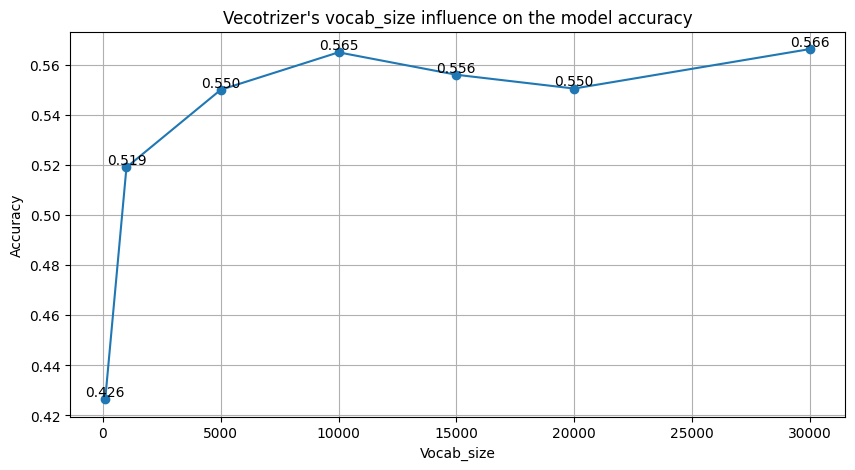

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Vecotrizer's vocab_size influence on the model accuracy")
plt.xlabel("Vocab_size")
plt.ylabel("Accuracy")
plt.plot(MAX_FEATURES, max_feature_acc, marker='o')
for i, acc in enumerate(max_feature_acc):
    plt.text(MAX_FEATURES[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

### Testowanie parametru lowercase
dla vocab_size = 10_000, ponieważ odniósł on podobne wyniki co 30_000 a przyspieszy to obliczenia

In [ ]:
lower_case_acc = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for lc in LOWERCASE :
  print(f"Training with lowercase : {lc}")
  model = SimpleNet(10_000, n_classes=5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

  vectorizer = create_vectorizer(max_feature=10_000, lowercase=lc)

  accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=20, verbose=True)

  lower_case_acc.append(accuracy)

Training with lowercase : True


100%|██████████| 782/782 [00:04<00:00, 163.30it/s]


(Epoch 1/[train]) Loss:	1.605   Accuracy: 0.210   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 173.25it/s]


(Epoch 1/[val]) Loss:	1.590   Accuracy: 0.291   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 161.30it/s]


(Epoch 2/[train]) Loss:	1.522   Accuracy: 0.344   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 216.78it/s]


(Epoch 2/[val]) Loss:	1.428   Accuracy: 0.345   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 168.08it/s]


(Epoch 3/[train]) Loss:	1.346   Accuracy: 0.381   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 214.06it/s]


(Epoch 3/[val]) Loss:	1.275   Accuracy: 0.449   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:05<00:00, 155.33it/s]


(Epoch 4/[train]) Loss:	1.239   Accuracy: 0.446   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 212.89it/s]


(Epoch 4/[val]) Loss:	1.200   Accuracy: 0.485   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 171.44it/s]


(Epoch 5/[train]) Loss:	1.185   Accuracy: 0.473   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 215.88it/s]


(Epoch 5/[val]) Loss:	1.160   Accuracy: 0.496   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 155.21it/s]


(Epoch 6/[train]) Loss:	1.151   Accuracy: 0.486   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 217.08it/s]


(Epoch 6/[val]) Loss:	1.133   Accuracy: 0.505   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:04<00:00, 171.67it/s]


(Epoch 7/[train]) Loss:	1.123   Accuracy: 0.500   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 217.66it/s]


(Epoch 7/[val]) Loss:	1.112   Accuracy: 0.519   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:04<00:00, 166.69it/s]


(Epoch 8/[train]) Loss:	1.103   Accuracy: 0.511   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 177.29it/s]


(Epoch 8/[val]) Loss:	1.095   Accuracy: 0.525   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:04<00:00, 161.40it/s]


(Epoch 9/[train]) Loss:	1.084   Accuracy: 0.523   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 214.72it/s]


(Epoch 9/[val]) Loss:	1.081   Accuracy: 0.529   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:04<00:00, 171.22it/s]


(Epoch 10/[train]) Loss:	1.068   Accuracy: 0.530   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 219.66it/s]


(Epoch 10/[val]) Loss:	1.069   Accuracy: 0.536   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 156.56it/s]


(Epoch 11/[train]) Loss:	1.054   Accuracy: 0.539   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 217.74it/s]


(Epoch 11/[val]) Loss:	1.060   Accuracy: 0.540   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 170.97it/s]


(Epoch 12/[train]) Loss:	1.044   Accuracy: 0.543   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 220.36it/s]


(Epoch 12/[val]) Loss:	1.053   Accuracy: 0.543   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:05<00:00, 156.14it/s]


(Epoch 13/[train]) Loss:	1.034   Accuracy: 0.551   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 215.49it/s]


(Epoch 13/[val]) Loss:	1.047   Accuracy: 0.548   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 170.25it/s]


(Epoch 14/[train]) Loss:	1.027   Accuracy: 0.552   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 220.76it/s]


(Epoch 14/[val]) Loss:	1.043   Accuracy: 0.551   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:04<00:00, 169.70it/s]


(Epoch 15/[train]) Loss:	1.022   Accuracy: 0.555   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 172.58it/s]


(Epoch 15/[val]) Loss:	1.040   Accuracy: 0.553   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 160.77it/s]


(Epoch 16/[train]) Loss:	1.017   Accuracy: 0.559   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 220.97it/s]


(Epoch 16/[val]) Loss:	1.037   Accuracy: 0.555   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:04<00:00, 172.40it/s]


(Epoch 17/[train]) Loss:	1.014   Accuracy: 0.559   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 220.44it/s]


(Epoch 17/[val]) Loss:	1.035   Accuracy: 0.556   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:05<00:00, 155.42it/s]


(Epoch 18/[train]) Loss:	1.012   Accuracy: 0.559   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 217.76it/s]


(Epoch 18/[val]) Loss:	1.034   Accuracy: 0.557   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 171.04it/s]


(Epoch 19/[train]) Loss:	1.010   Accuracy: 0.560   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 210.24it/s]


(Epoch 19/[val]) Loss:	1.033   Accuracy: 0.557   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:04<00:00, 156.44it/s]


(Epoch 20/[train]) Loss:	1.008   Accuracy: 0.562   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 220.31it/s]


(Epoch 20/[val]) Loss:	1.032   Accuracy: 0.558   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 293.45it/s]


Training with lowercase : False


100%|██████████| 782/782 [00:04<00:00, 161.71it/s]


(Epoch 1/[train]) Loss:	1.601   Accuracy: 0.222   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 173.73it/s]


(Epoch 1/[val]) Loss:	1.571   Accuracy: 0.373   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 158.82it/s]


(Epoch 2/[train]) Loss:	1.495   Accuracy: 0.373   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 212.00it/s]


(Epoch 2/[val]) Loss:	1.399   Accuracy: 0.389   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 168.13it/s]


(Epoch 3/[train]) Loss:	1.328   Accuracy: 0.413   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 217.36it/s]


(Epoch 3/[val]) Loss:	1.260   Accuracy: 0.440   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:05<00:00, 153.92it/s]


(Epoch 4/[train]) Loss:	1.230   Accuracy: 0.446   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 211.57it/s]


(Epoch 4/[val]) Loss:	1.190   Accuracy: 0.477   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 168.57it/s]


(Epoch 5/[train]) Loss:	1.177   Accuracy: 0.469   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 206.76it/s]


(Epoch 5/[val]) Loss:	1.152   Accuracy: 0.501   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 151.25it/s]


(Epoch 6/[train]) Loss:	1.143   Accuracy: 0.487   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 217.40it/s]


(Epoch 6/[val]) Loss:	1.127   Accuracy: 0.505   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:04<00:00, 169.50it/s]


(Epoch 7/[train]) Loss:	1.117   Accuracy: 0.499   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 218.39it/s]


(Epoch 7/[val]) Loss:	1.109   Accuracy: 0.514   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:04<00:00, 158.57it/s]


(Epoch 8/[train]) Loss:	1.097   Accuracy: 0.510   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 172.20it/s]


(Epoch 8/[val]) Loss:	1.094   Accuracy: 0.521   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:04<00:00, 162.22it/s]


(Epoch 9/[train]) Loss:	1.079   Accuracy: 0.518   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 214.96it/s]


(Epoch 9/[val]) Loss:	1.082   Accuracy: 0.530   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:04<00:00, 170.64it/s]


(Epoch 10/[train]) Loss:	1.065   Accuracy: 0.531   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 203.91it/s]


(Epoch 10/[val]) Loss:	1.072   Accuracy: 0.536   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:05<00:00, 153.46it/s]


(Epoch 11/[train]) Loss:	1.053   Accuracy: 0.536   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 220.14it/s]


(Epoch 11/[val]) Loss:	1.063   Accuracy: 0.540   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 168.38it/s]


(Epoch 12/[train]) Loss:	1.041   Accuracy: 0.543   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 217.65it/s]


(Epoch 12/[val]) Loss:	1.056   Accuracy: 0.543   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:05<00:00, 151.87it/s]


(Epoch 13/[train]) Loss:	1.032   Accuracy: 0.549   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 205.79it/s]


(Epoch 13/[val]) Loss:	1.050   Accuracy: 0.547   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 167.11it/s]


(Epoch 14/[train]) Loss:	1.024   Accuracy: 0.555   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 211.18it/s]


(Epoch 14/[val]) Loss:	1.046   Accuracy: 0.550   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:05<00:00, 154.17it/s]


(Epoch 15/[train]) Loss:	1.018   Accuracy: 0.556   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 170.74it/s]


(Epoch 15/[val]) Loss:	1.042   Accuracy: 0.553   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 164.71it/s]


(Epoch 16/[train]) Loss:	1.014   Accuracy: 0.558   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 214.99it/s]


(Epoch 16/[val]) Loss:	1.039   Accuracy: 0.553   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:04<00:00, 166.95it/s]


(Epoch 17/[train]) Loss:	1.010   Accuracy: 0.561   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 163.54it/s]


(Epoch 17/[val]) Loss:	1.037   Accuracy: 0.553   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:05<00:00, 155.71it/s]


(Epoch 18/[train]) Loss:	1.008   Accuracy: 0.564   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 213.27it/s]


(Epoch 18/[val]) Loss:	1.035   Accuracy: 0.555   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 168.32it/s]


(Epoch 19/[train]) Loss:	1.005   Accuracy: 0.563   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 214.50it/s]


(Epoch 19/[val]) Loss:	1.034   Accuracy: 0.556   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:05<00:00, 152.06it/s]


(Epoch 20/[train]) Loss:	1.002   Accuracy: 0.565   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 218.88it/s]


(Epoch 20/[val]) Loss:	1.033   Accuracy: 0.557   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 290.91it/s]


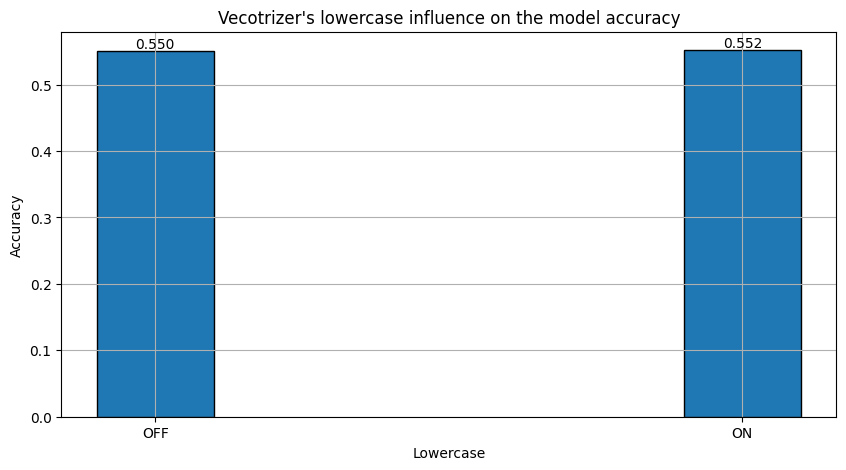

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Vecotrizer's lowercase influence on the model accuracy")
plt.xlabel("Lowercase")
plt.ylabel("Accuracy")
plt.bar(LOWERCASE, lower_case_acc, width=0.2, edgecolor='black', tick_label=['ON', 'OFF'])
for i, acc in enumerate(lower_case_acc):
    plt.text(LOWERCASE[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()


### Testowanie n_gramów
- vocab_size = 10_000
- lowercase = True

In [ ]:
n_grams_acc = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for ngram in N_GRAM_RANGE :
  print(f"Training with ngram : {ngram}")
  model = SimpleNet(10_000, n_classes=5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

  vectorizer = create_vectorizer(max_feature=10_000, lowercase=True, ngram_range=ngram)

  accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=20, verbose=True)

  n_grams_acc.append(accuracy)

Training with ngram : (1, 1)


100%|██████████| 782/782 [00:05<00:00, 150.18it/s]


(Epoch 1/[train]) Loss:	1.605   Accuracy: 0.241   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 160.49it/s]


(Epoch 1/[val]) Loss:	1.580   Accuracy: 0.331   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 158.18it/s]


(Epoch 2/[train]) Loss:	1.513   Accuracy: 0.353   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 206.40it/s]


(Epoch 2/[val]) Loss:	1.427   Accuracy: 0.366   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 160.84it/s]


(Epoch 3/[train]) Loss:	1.357   Accuracy: 0.386   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 169.55it/s]


(Epoch 3/[val]) Loss:	1.288   Accuracy: 0.405   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:05<00:00, 151.00it/s]


(Epoch 4/[train]) Loss:	1.258   Accuracy: 0.436   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 215.33it/s]


(Epoch 4/[val]) Loss:	1.217   Accuracy: 0.461   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 161.04it/s]


(Epoch 5/[train]) Loss:	1.206   Accuracy: 0.454   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 207.76it/s]


(Epoch 5/[val]) Loss:	1.178   Accuracy: 0.479   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 146.90it/s]


(Epoch 6/[train]) Loss:	1.175   Accuracy: 0.464   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 203.83it/s]


(Epoch 6/[val]) Loss:	1.154   Accuracy: 0.489   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:04<00:00, 161.45it/s]


(Epoch 7/[train]) Loss:	1.154   Accuracy: 0.475   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 217.67it/s]


(Epoch 7/[val]) Loss:	1.138   Accuracy: 0.495   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:05<00:00, 149.21it/s]


(Epoch 8/[train]) Loss:	1.137   Accuracy: 0.483   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 213.30it/s]


(Epoch 8/[val]) Loss:	1.126   Accuracy: 0.503   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:04<00:00, 162.35it/s]


(Epoch 9/[train]) Loss:	1.125   Accuracy: 0.489   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 203.40it/s]


(Epoch 9/[val]) Loss:	1.117   Accuracy: 0.509   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:05<00:00, 147.88it/s]


(Epoch 10/[train]) Loss:	1.113   Accuracy: 0.494   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 177.91it/s]


(Epoch 10/[val]) Loss:	1.109   Accuracy: 0.516   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 158.19it/s]


(Epoch 11/[train]) Loss:	1.103   Accuracy: 0.500   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 207.18it/s]


(Epoch 11/[val]) Loss:	1.104   Accuracy: 0.519   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 159.47it/s]


(Epoch 12/[train]) Loss:	1.095   Accuracy: 0.505   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 169.05it/s]


(Epoch 12/[val]) Loss:	1.098   Accuracy: 0.521   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:04<00:00, 157.19it/s]


(Epoch 13/[train]) Loss:	1.088   Accuracy: 0.509   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 206.77it/s]


(Epoch 13/[val]) Loss:	1.094   Accuracy: 0.523   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 162.44it/s]


(Epoch 14/[train]) Loss:	1.083   Accuracy: 0.513   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 205.12it/s]


(Epoch 14/[val]) Loss:	1.090   Accuracy: 0.526   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:05<00:00, 148.24it/s]


(Epoch 15/[train]) Loss:	1.078   Accuracy: 0.516   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 209.45it/s]


(Epoch 15/[val]) Loss:	1.087   Accuracy: 0.529   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 164.39it/s]


(Epoch 16/[train]) Loss:	1.073   Accuracy: 0.519   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 210.15it/s]


(Epoch 16/[val]) Loss:	1.085   Accuracy: 0.530   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:05<00:00, 149.51it/s]


(Epoch 17/[train]) Loss:	1.070   Accuracy: 0.521   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 209.10it/s]


(Epoch 17/[val]) Loss:	1.083   Accuracy: 0.531   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 164.44it/s]


(Epoch 18/[train]) Loss:	1.067   Accuracy: 0.523   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 205.70it/s]


(Epoch 18/[val]) Loss:	1.081   Accuracy: 0.530   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:05<00:00, 148.77it/s]


(Epoch 19/[train]) Loss:	1.066   Accuracy: 0.523   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 216.41it/s]


(Epoch 19/[val]) Loss:	1.080   Accuracy: 0.531   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:04<00:00, 165.42it/s]


(Epoch 20/[train]) Loss:	1.063   Accuracy: 0.526   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 218.62it/s]


(Epoch 20/[val]) Loss:	1.079   Accuracy: 0.531   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 278.30it/s]


Training with ngram : (1, 2)


100%|██████████| 782/782 [00:05<00:00, 150.46it/s]


(Epoch 1/[train]) Loss:	1.606   Accuracy: 0.228   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 176.74it/s]


(Epoch 1/[val]) Loss:	1.591   Accuracy: 0.361   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 161.14it/s]


(Epoch 2/[train]) Loss:	1.533   Accuracy: 0.394   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 210.20it/s]


(Epoch 2/[val]) Loss:	1.447   Accuracy: 0.479   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 166.51it/s]


(Epoch 3/[train]) Loss:	1.366   Accuracy: 0.425   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 167.16it/s]


(Epoch 3/[val]) Loss:	1.284   Accuracy: 0.484   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:04<00:00, 158.82it/s]


(Epoch 4/[train]) Loss:	1.244   Accuracy: 0.470   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 211.89it/s]


(Epoch 4/[val]) Loss:	1.195   Accuracy: 0.524   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 167.71it/s]


(Epoch 5/[train]) Loss:	1.173   Accuracy: 0.501   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 214.65it/s]


(Epoch 5/[val]) Loss:	1.139   Accuracy: 0.534   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 150.37it/s]


(Epoch 6/[train]) Loss:	1.124   Accuracy: 0.521   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 206.33it/s]


(Epoch 6/[val]) Loss:	1.102   Accuracy: 0.543   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:04<00:00, 161.48it/s]


(Epoch 7/[train]) Loss:	1.088   Accuracy: 0.535   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 215.30it/s]


(Epoch 7/[val]) Loss:	1.075   Accuracy: 0.549   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:05<00:00, 154.66it/s]


(Epoch 8/[train]) Loss:	1.061   Accuracy: 0.544   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 204.45it/s]


(Epoch 8/[val]) Loss:	1.055   Accuracy: 0.556   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:04<00:00, 160.45it/s]


(Epoch 9/[train]) Loss:	1.040   Accuracy: 0.554   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 208.74it/s]


(Epoch 9/[val]) Loss:	1.040   Accuracy: 0.560   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:05<00:00, 152.90it/s]


(Epoch 10/[train]) Loss:	1.024   Accuracy: 0.560   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 159.26it/s]


(Epoch 10/[val]) Loss:	1.029   Accuracy: 0.563   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 166.67it/s]


(Epoch 11/[train]) Loss:	1.011   Accuracy: 0.566   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 206.44it/s]


(Epoch 11/[val]) Loss:	1.021   Accuracy: 0.566   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 161.19it/s]


(Epoch 12/[train]) Loss:	1.002   Accuracy: 0.570   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 174.06it/s]


(Epoch 12/[val]) Loss:	1.016   Accuracy: 0.566   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:05<00:00, 154.08it/s]


(Epoch 13/[train]) Loss:	0.994   Accuracy: 0.573   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 207.94it/s]


(Epoch 13/[val]) Loss:	1.012   Accuracy: 0.568   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 161.09it/s]


(Epoch 14/[train]) Loss:	0.988   Accuracy: 0.575   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 202.84it/s]


(Epoch 14/[val]) Loss:	1.009   Accuracy: 0.569   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:05<00:00, 150.30it/s]


(Epoch 15/[train]) Loss:	0.983   Accuracy: 0.578   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 208.45it/s]


(Epoch 15/[val]) Loss:	1.007   Accuracy: 0.570   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 161.57it/s]


(Epoch 16/[train]) Loss:	0.979   Accuracy: 0.580   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 210.97it/s]


(Epoch 16/[val]) Loss:	1.005   Accuracy: 0.571   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:05<00:00, 150.91it/s]


(Epoch 17/[train]) Loss:	0.977   Accuracy: 0.579   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 197.76it/s]


(Epoch 17/[val]) Loss:	1.004   Accuracy: 0.571   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 156.85it/s]


(Epoch 18/[train]) Loss:	0.976   Accuracy: 0.582   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 209.06it/s]


(Epoch 18/[val]) Loss:	1.003   Accuracy: 0.571   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:05<00:00, 153.03it/s]


(Epoch 19/[train]) Loss:	0.972   Accuracy: 0.582   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 159.66it/s]


(Epoch 19/[val]) Loss:	1.002   Accuracy: 0.572   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:04<00:00, 158.98it/s]


(Epoch 20/[train]) Loss:	0.972   Accuracy: 0.582   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 196.40it/s]


(Epoch 20/[val]) Loss:	1.001   Accuracy: 0.572   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 275.06it/s]


Training with ngram : (1, 3)


100%|██████████| 782/782 [00:04<00:00, 160.54it/s]


(Epoch 1/[train]) Loss:	1.613   Accuracy: 0.212   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 203.11it/s]


(Epoch 1/[val]) Loss:	1.601   Accuracy: 0.226   lr: 0.0001


100%|██████████| 782/782 [00:05<00:00, 144.95it/s]


(Epoch 2/[train]) Loss:	1.567   Accuracy: 0.280   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 202.94it/s]


(Epoch 2/[val]) Loss:	1.518   Accuracy: 0.329   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:04<00:00, 161.99it/s]


(Epoch 3/[train]) Loss:	1.460   Accuracy: 0.357   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 207.34it/s]


(Epoch 3/[val]) Loss:	1.404   Accuracy: 0.373   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:05<00:00, 148.07it/s]


(Epoch 4/[train]) Loss:	1.357   Accuracy: 0.382   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 201.55it/s]


(Epoch 4/[val]) Loss:	1.314   Accuracy: 0.394   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:04<00:00, 162.66it/s]


(Epoch 5/[train]) Loss:	1.271   Accuracy: 0.426   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 199.86it/s]


(Epoch 5/[val]) Loss:	1.226   Accuracy: 0.483   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:05<00:00, 154.21it/s]


(Epoch 6/[train]) Loss:	1.193   Accuracy: 0.490   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 166.64it/s]


(Epoch 6/[val]) Loss:	1.160   Accuracy: 0.529   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:05<00:00, 153.20it/s]


(Epoch 7/[train]) Loss:	1.143   Accuracy: 0.510   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 202.87it/s]


(Epoch 7/[val]) Loss:	1.119   Accuracy: 0.538   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:04<00:00, 160.08it/s]


(Epoch 8/[train]) Loss:	1.109   Accuracy: 0.519   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 182.01it/s]


(Epoch 8/[val]) Loss:	1.092   Accuracy: 0.548   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:05<00:00, 149.69it/s]


(Epoch 9/[train]) Loss:	1.084   Accuracy: 0.530   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 198.08it/s]


(Epoch 9/[val]) Loss:	1.072   Accuracy: 0.553   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:04<00:00, 159.80it/s]


(Epoch 10/[train]) Loss:	1.067   Accuracy: 0.534   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 206.78it/s]


(Epoch 10/[val]) Loss:	1.058   Accuracy: 0.557   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:05<00:00, 150.00it/s]


(Epoch 11/[train]) Loss:	1.052   Accuracy: 0.541   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 204.78it/s]


(Epoch 11/[val]) Loss:	1.048   Accuracy: 0.561   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 164.57it/s]


(Epoch 12/[train]) Loss:	1.042   Accuracy: 0.546   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 206.36it/s]


(Epoch 12/[val]) Loss:	1.040   Accuracy: 0.563   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:05<00:00, 150.52it/s]


(Epoch 13/[train]) Loss:	1.032   Accuracy: 0.551   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 210.85it/s]


(Epoch 13/[val]) Loss:	1.035   Accuracy: 0.563   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 162.90it/s]


(Epoch 14/[train]) Loss:	1.025   Accuracy: 0.554   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 207.17it/s]


(Epoch 14/[val]) Loss:	1.031   Accuracy: 0.565   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:04<00:00, 157.02it/s]


(Epoch 15/[train]) Loss:	1.020   Accuracy: 0.557   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 154.93it/s]


(Epoch 15/[val]) Loss:	1.027   Accuracy: 0.565   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:04<00:00, 157.89it/s]


(Epoch 16/[train]) Loss:	1.015   Accuracy: 0.557   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 196.24it/s]


(Epoch 16/[val]) Loss:	1.025   Accuracy: 0.566   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:04<00:00, 165.26it/s]


(Epoch 17/[train]) Loss:	1.012   Accuracy: 0.560   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 173.80it/s]


(Epoch 17/[val]) Loss:	1.023   Accuracy: 0.567   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:05<00:00, 151.44it/s]


(Epoch 18/[train]) Loss:	1.011   Accuracy: 0.560   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 207.62it/s]


(Epoch 18/[val]) Loss:	1.022   Accuracy: 0.567   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 156.59it/s]


(Epoch 19/[train]) Loss:	1.007   Accuracy: 0.563   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 202.88it/s]


(Epoch 19/[val]) Loss:	1.021   Accuracy: 0.568   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:05<00:00, 146.67it/s]


(Epoch 20/[train]) Loss:	1.007   Accuracy: 0.562   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 200.51it/s]


(Epoch 20/[val]) Loss:	1.020   Accuracy: 0.568   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 259.82it/s]


Training with ngram : (1, 4)


100%|██████████| 782/782 [00:04<00:00, 160.72it/s]


(Epoch 1/[train]) Loss:	1.607   Accuracy: 0.222   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 208.68it/s]


(Epoch 1/[val]) Loss:	1.578   Accuracy: 0.365   lr: 0.0001


100%|██████████| 782/782 [00:04<00:00, 165.14it/s]


(Epoch 2/[train]) Loss:	1.505   Accuracy: 0.369   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 199.18it/s]


(Epoch 2/[val]) Loss:	1.409   Accuracy: 0.395   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:05<00:00, 153.02it/s]


(Epoch 3/[train]) Loss:	1.340   Accuracy: 0.398   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 209.99it/s]


(Epoch 3/[val]) Loss:	1.269   Accuracy: 0.432   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:04<00:00, 166.85it/s]


(Epoch 4/[train]) Loss:	1.241   Accuracy: 0.436   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 210.74it/s]


(Epoch 4/[val]) Loss:	1.199   Accuracy: 0.472   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:05<00:00, 148.92it/s]


(Epoch 5/[train]) Loss:	1.188   Accuracy: 0.460   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 206.73it/s]


(Epoch 5/[val]) Loss:	1.160   Accuracy: 0.487   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:04<00:00, 161.98it/s]


(Epoch 6/[train]) Loss:	1.155   Accuracy: 0.474   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 202.58it/s]


(Epoch 6/[val]) Loss:	1.136   Accuracy: 0.495   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:05<00:00, 148.12it/s]


(Epoch 7/[train]) Loss:	1.131   Accuracy: 0.484   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 192.24it/s]


(Epoch 7/[val]) Loss:	1.118   Accuracy: 0.505   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:04<00:00, 161.70it/s]


(Epoch 8/[train]) Loss:	1.113   Accuracy: 0.495   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 215.42it/s]


(Epoch 8/[val]) Loss:	1.106   Accuracy: 0.512   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:05<00:00, 153.78it/s]


(Epoch 9/[train]) Loss:	1.098   Accuracy: 0.504   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 150.75it/s]


(Epoch 9/[val]) Loss:	1.095   Accuracy: 0.518   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:04<00:00, 160.68it/s]


(Epoch 10/[train]) Loss:	1.087   Accuracy: 0.510   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 205.20it/s]


(Epoch 10/[val]) Loss:	1.087   Accuracy: 0.524   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:04<00:00, 161.99it/s]


(Epoch 11/[train]) Loss:	1.075   Accuracy: 0.517   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 164.10it/s]


(Epoch 11/[val]) Loss:	1.079   Accuracy: 0.526   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:04<00:00, 156.54it/s]


(Epoch 12/[train]) Loss:	1.067   Accuracy: 0.523   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 211.27it/s]


(Epoch 12/[val]) Loss:	1.073   Accuracy: 0.530   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:04<00:00, 166.96it/s]


(Epoch 13/[train]) Loss:	1.059   Accuracy: 0.526   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 217.01it/s]


(Epoch 13/[val]) Loss:	1.068   Accuracy: 0.535   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:05<00:00, 152.56it/s]


(Epoch 14/[train]) Loss:	1.052   Accuracy: 0.532   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 212.07it/s]


(Epoch 14/[val]) Loss:	1.064   Accuracy: 0.537   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:04<00:00, 164.75it/s]


(Epoch 15/[train]) Loss:	1.047   Accuracy: 0.537   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 209.02it/s]


(Epoch 15/[val]) Loss:	1.061   Accuracy: 0.539   lr: 2.8549663646838717e-05


100%|██████████| 782/782 [00:05<00:00, 153.14it/s]


(Epoch 16/[train]) Loss:	1.041   Accuracy: 0.539   lr: 2.3180194846605367e-05


100%|██████████| 79/79 [00:00<00:00, 212.45it/s]


(Epoch 16/[val]) Loss:	1.058   Accuracy: 0.541   lr: 2.3180194846605367e-05


100%|██████████| 782/782 [00:04<00:00, 163.22it/s]


(Epoch 17/[train]) Loss:	1.039   Accuracy: 0.540   lr: 1.859423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 215.76it/s]


(Epoch 17/[val]) Loss:	1.055   Accuracy: 0.543   lr: 1.859423525312737e-05


100%|██████████| 782/782 [00:04<00:00, 160.70it/s]


(Epoch 18/[train]) Loss:	1.036   Accuracy: 0.541   lr: 1.490470641152345e-05


100%|██████████| 79/79 [00:00<00:00, 177.92it/s]


(Epoch 18/[val]) Loss:	1.054   Accuracy: 0.543   lr: 1.490470641152345e-05


100%|██████████| 782/782 [00:04<00:00, 161.48it/s]


(Epoch 19/[train]) Loss:	1.033   Accuracy: 0.545   lr: 1.2202456766718093e-05


100%|██████████| 79/79 [00:00<00:00, 214.74it/s]


(Epoch 19/[val]) Loss:	1.052   Accuracy: 0.544   lr: 1.2202456766718093e-05


100%|██████████| 782/782 [00:04<00:00, 166.47it/s]


(Epoch 20/[train]) Loss:	1.032   Accuracy: 0.544   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:00<00:00, 213.53it/s]


(Epoch 20/[val]) Loss:	1.051   Accuracy: 0.544   lr: 1.0554024673218807e-05


100%|██████████| 157/157 [00:00<00:00, 254.78it/s]


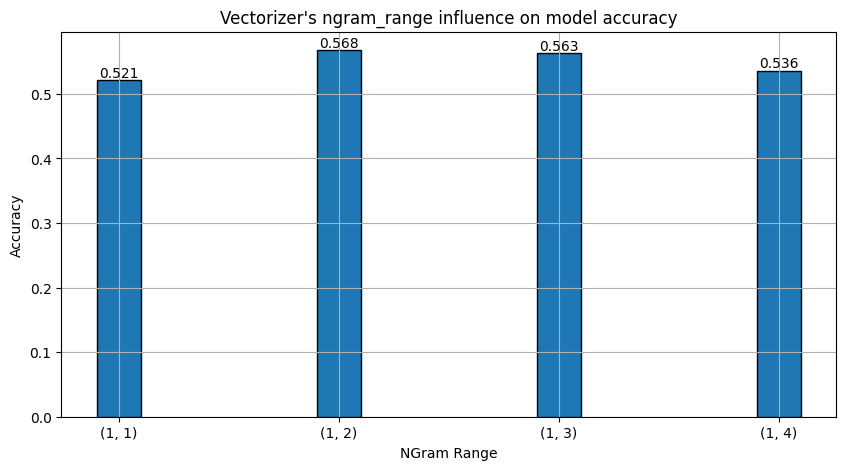

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Vectorizer's ngram_range influence on model accuracy")
plt.xlabel("NGram Range")
plt.ylabel("Accuracy")

x_pos = range(len(N_GRAM_RANGE))

bars = plt.bar(x_pos, n_grams_acc, width=0.2, edgecolor='black')

plt.xticks(x_pos, [str(ngram) for ngram in N_GRAM_RANGE])

for bar, acc in zip(bars, n_grams_acc):
    plt.text(bar.get_x() + bar.get_width() / 2, acc, f'{acc:.3f}', ha='center', va='bottom')

plt.grid(True)
plt.show()

### Testowanie vocab size dla ngramów 1-2 i 1-3

In [15]:
dict_of_acc = {}
for ngram in [(1,2), (1,3)] :
  dict_of_acc[ngram] = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for ngram in [(1,2), (1,3)] :
  for vocab_size in [10_000, 15_000, 20_000, 25_000, 30_000] :
    print(f"Training with vocab_size : {vocab_size} and ngram : {ngram}")
    model = SimpleNet(vocab_size, n_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=True, ngram_range=ngram)

    accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=20, verbose=False)

    dict_of_acc[ngram].append(accuracy)


Training with vocab_size : 10000 and ngram : (1, 2)


100%|██████████| 157/157 [00:01<00:00, 150.01it/s]


Training with vocab_size : 15000 and ngram : (1, 2)


100%|██████████| 157/157 [00:01<00:00, 125.66it/s]


Training with vocab_size : 20000 and ngram : (1, 2)


100%|██████████| 157/157 [00:06<00:00, 22.46it/s]


Training with vocab_size : 25000 and ngram : (1, 2)


100%|██████████| 157/157 [00:10<00:00, 14.54it/s]


Training with vocab_size : 30000 and ngram : (1, 2)


100%|██████████| 157/157 [00:08<00:00, 18.71it/s]


Training with vocab_size : 10000 and ngram : (1, 3)


100%|██████████| 157/157 [00:00<00:00, 186.19it/s]


Training with vocab_size : 15000 and ngram : (1, 3)


100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


Training with vocab_size : 20000 and ngram : (1, 3)


100%|██████████| 157/157 [00:05<00:00, 30.17it/s]


Training with vocab_size : 25000 and ngram : (1, 3)


100%|██████████| 157/157 [00:08<00:00, 19.34it/s]


Training with vocab_size : 30000 and ngram : (1, 3)


100%|██████████| 157/157 [00:06<00:00, 22.61it/s]


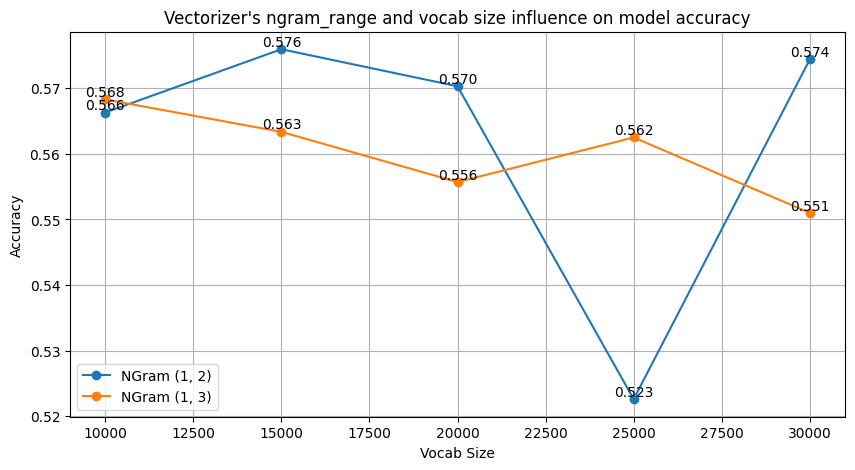

In [16]:
plt.figure(figsize=(10,5))
plt.title("Vectorizer's ngram_range and vocab size influence on model accuracy")
plt.xlabel("Vocab Size")
plt.ylabel("Accuracy")

for ngram in [(1,2), (1,3)] :
  plt.plot([10_000, 15_000, 20_000, 25_000, 30_000], dict_of_acc[ngram], marker='o', label=f"NGram {ngram}")
  for i, acc in enumerate(dict_of_acc[ngram]):
      plt.text([10_000, 15_000, 20_000, 25_000, 30_000][i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.legend()
plt.grid(True)

### Testowanie parametrów sublinear_tf oraz binary

In [20]:
vocab_size = 15_000
n_gram = (1,2)

binary_acc = []

for binary in BINARY_VALUES:
  print(f"Training with binary : {binary} vocab_size : {vocab_size} ngram : {n_gram}")
  model = SimpleNet(vocab_size, n_classes=5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

  vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=True, ngram_range=n_gram, binary=binary)

  accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=15, verbose=True)

  binary_acc.append(accuracy)

Training with binary : False vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:10<00:00, 73.59it/s]


(Epoch 1/[train]) Loss:	1.603   Accuracy: 0.268   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 80.53it/s]


(Epoch 1/[val]) Loss:	1.578   Accuracy: 0.373   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 78.18it/s]


(Epoch 2/[train]) Loss:	1.503   Accuracy: 0.374   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 80.73it/s]


(Epoch 2/[val]) Loss:	1.410   Accuracy: 0.405   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:11<00:00, 68.60it/s]


(Epoch 3/[train]) Loss:	1.332   Accuracy: 0.425   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 87.33it/s]


(Epoch 3/[val]) Loss:	1.264   Accuracy: 0.451   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:11<00:00, 66.82it/s]


(Epoch 4/[train]) Loss:	1.227   Accuracy: 0.454   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:01<00:00, 78.73it/s]


(Epoch 4/[val]) Loss:	1.192   Accuracy: 0.481   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:10<00:00, 73.17it/s]


(Epoch 5/[train]) Loss:	1.168   Accuracy: 0.477   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 99.49it/s] 


(Epoch 5/[val]) Loss:	1.152   Accuracy: 0.487   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:09<00:00, 79.79it/s]


(Epoch 6/[train]) Loss:	1.133   Accuracy: 0.488   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 97.35it/s]


(Epoch 6/[val]) Loss:	1.131   Accuracy: 0.495   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 75.17it/s]


(Epoch 7/[train]) Loss:	1.110   Accuracy: 0.501   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 93.70it/s]


(Epoch 7/[val]) Loss:	1.118   Accuracy: 0.497   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:09<00:00, 79.07it/s]


(Epoch 8/[train]) Loss:	1.092   Accuracy: 0.508   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:01<00:00, 77.46it/s]


(Epoch 8/[val]) Loss:	1.109   Accuracy: 0.503   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 76.47it/s]


(Epoch 9/[train]) Loss:	1.079   Accuracy: 0.515   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 88.30it/s]


(Epoch 9/[val]) Loss:	1.103   Accuracy: 0.507   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:10<00:00, 72.79it/s]


(Epoch 10/[train]) Loss:	1.068   Accuracy: 0.521   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 82.10it/s]


(Epoch 10/[val]) Loss:	1.098   Accuracy: 0.508   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:10<00:00, 74.77it/s]


(Epoch 11/[train]) Loss:	1.059   Accuracy: 0.525   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:01<00:00, 66.65it/s]


(Epoch 11/[val]) Loss:	1.094   Accuracy: 0.511   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:10<00:00, 72.21it/s]


(Epoch 12/[train]) Loss:	1.051   Accuracy: 0.530   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:01<00:00, 75.30it/s]


(Epoch 12/[val]) Loss:	1.091   Accuracy: 0.513   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:09<00:00, 79.62it/s]


(Epoch 13/[train]) Loss:	1.045   Accuracy: 0.534   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:01<00:00, 75.44it/s]


(Epoch 13/[val]) Loss:	1.088   Accuracy: 0.515   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:11<00:00, 70.04it/s]


(Epoch 14/[train]) Loss:	1.040   Accuracy: 0.536   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 99.01it/s] 


(Epoch 14/[val]) Loss:	1.086   Accuracy: 0.516   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:09<00:00, 79.89it/s]


(Epoch 15/[train]) Loss:	1.035   Accuracy: 0.539   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 89.55it/s]


(Epoch 15/[val]) Loss:	1.084   Accuracy: 0.518   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 124.66it/s]


Training with binary : True vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:11<00:00, 68.07it/s]


(Epoch 1/[train]) Loss:	1.614   Accuracy: 0.204   lr: 0.0001


100%|██████████| 79/79 [00:01<00:00, 77.54it/s]


(Epoch 1/[val]) Loss:	1.603   Accuracy: 0.228   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 77.73it/s]


(Epoch 2/[train]) Loss:	1.575   Accuracy: 0.377   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 105.67it/s]


(Epoch 2/[val]) Loss:	1.522   Accuracy: 0.435   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:09<00:00, 78.93it/s]


(Epoch 3/[train]) Loss:	1.434   Accuracy: 0.429   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


(Epoch 3/[val]) Loss:	1.342   Accuracy: 0.464   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:10<00:00, 75.84it/s]


(Epoch 4/[train]) Loss:	1.275   Accuracy: 0.470   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:01<00:00, 75.62it/s]


(Epoch 4/[val]) Loss:	1.214   Accuracy: 0.500   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:09<00:00, 80.68it/s]


(Epoch 5/[train]) Loss:	1.176   Accuracy: 0.505   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 98.61it/s] 


(Epoch 5/[val]) Loss:	1.140   Accuracy: 0.530   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:10<00:00, 74.89it/s]


(Epoch 6/[train]) Loss:	1.115   Accuracy: 0.525   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 85.94it/s]


(Epoch 6/[val]) Loss:	1.094   Accuracy: 0.543   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 76.50it/s]


(Epoch 7/[train]) Loss:	1.073   Accuracy: 0.541   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 93.30it/s]


(Epoch 7/[val]) Loss:	1.064   Accuracy: 0.552   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:09<00:00, 81.35it/s]


(Epoch 8/[train]) Loss:	1.043   Accuracy: 0.551   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 83.82it/s]


(Epoch 8/[val]) Loss:	1.044   Accuracy: 0.559   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 74.86it/s]


(Epoch 9/[train]) Loss:	1.020   Accuracy: 0.561   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 80.69it/s]


(Epoch 9/[val]) Loss:	1.031   Accuracy: 0.562   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:09<00:00, 79.30it/s]


(Epoch 10/[train]) Loss:	1.003   Accuracy: 0.570   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 93.33it/s] 


(Epoch 10/[val]) Loss:	1.021   Accuracy: 0.564   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:10<00:00, 76.51it/s]


(Epoch 11/[train]) Loss:	0.990   Accuracy: 0.574   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 92.25it/s]


(Epoch 11/[val]) Loss:	1.014   Accuracy: 0.566   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:10<00:00, 73.88it/s]


(Epoch 12/[train]) Loss:	0.981   Accuracy: 0.579   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 92.22it/s]


(Epoch 12/[val]) Loss:	1.009   Accuracy: 0.567   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


(Epoch 13/[train]) Loss:	0.972   Accuracy: 0.581   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 81.13it/s]


(Epoch 13/[val]) Loss:	1.006   Accuracy: 0.569   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:10<00:00, 75.22it/s]


(Epoch 14/[train]) Loss:	0.966   Accuracy: 0.584   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 95.35it/s]


(Epoch 14/[val]) Loss:	1.003   Accuracy: 0.569   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:10<00:00, 75.01it/s]


(Epoch 15/[train]) Loss:	0.960   Accuracy: 0.586   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:01<00:00, 74.89it/s]


(Epoch 15/[val]) Loss:	1.001   Accuracy: 0.571   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 129.58it/s]


In [21]:
vocab_size = 15_000
n_gram = (1,2)

sublinear_acc = []

for sublinear in SUBLINEAR_VALUES:
  print(f"Training with sublinear : {sublinear}, vocab_size : {vocab_size}, ngram : {n_gram}")
  model = SimpleNet(vocab_size, n_classes=5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

  vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=True, ngram_range=n_gram, sublinear_tf=sublinear)

  accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=15, verbose=True)

  sublinear_acc.append(accuracy)

Training with sublinear : False, vocab_size : 15000, ngram : (1, 2)


100%|██████████| 782/782 [00:10<00:00, 73.85it/s]


(Epoch 1/[train]) Loss:	1.612   Accuracy: 0.201   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 88.28it/s]


(Epoch 1/[val]) Loss:	1.598   Accuracy: 0.262   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 77.87it/s]


(Epoch 2/[train]) Loss:	1.549   Accuracy: 0.383   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 87.51it/s]


(Epoch 2/[val]) Loss:	1.474   Accuracy: 0.452   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:10<00:00, 77.07it/s]


(Epoch 3/[train]) Loss:	1.384   Accuracy: 0.447   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:01<00:00, 74.52it/s]


(Epoch 3/[val]) Loss:	1.304   Accuracy: 0.464   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:10<00:00, 75.47it/s]


(Epoch 4/[train]) Loss:	1.255   Accuracy: 0.458   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 84.40it/s]


(Epoch 4/[val]) Loss:	1.211   Accuracy: 0.495   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:09<00:00, 81.14it/s]


(Epoch 5/[train]) Loss:	1.183   Accuracy: 0.490   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 100.89it/s]


(Epoch 5/[val]) Loss:	1.159   Accuracy: 0.513   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:10<00:00, 72.18it/s]


(Epoch 6/[train]) Loss:	1.138   Accuracy: 0.508   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 86.01it/s]


(Epoch 6/[val]) Loss:	1.126   Accuracy: 0.518   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 72.54it/s]


(Epoch 7/[train]) Loss:	1.106   Accuracy: 0.518   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 82.88it/s]


(Epoch 7/[val]) Loss:	1.102   Accuracy: 0.525   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:10<00:00, 77.34it/s]


(Epoch 8/[train]) Loss:	1.079   Accuracy: 0.531   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 95.83it/s] 


(Epoch 8/[val]) Loss:	1.083   Accuracy: 0.533   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 72.45it/s]


(Epoch 9/[train]) Loss:	1.057   Accuracy: 0.542   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 88.17it/s]


(Epoch 9/[val]) Loss:	1.068   Accuracy: 0.538   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:09<00:00, 80.85it/s]


(Epoch 10/[train]) Loss:	1.040   Accuracy: 0.550   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 82.56it/s]


(Epoch 10/[val]) Loss:	1.056   Accuracy: 0.542   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:10<00:00, 76.02it/s]


(Epoch 11/[train]) Loss:	1.025   Accuracy: 0.556   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 83.25it/s]


(Epoch 11/[val]) Loss:	1.046   Accuracy: 0.546   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:10<00:00, 76.56it/s]


(Epoch 12/[train]) Loss:	1.013   Accuracy: 0.560   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 104.72it/s]


(Epoch 12/[val]) Loss:	1.039   Accuracy: 0.552   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:09<00:00, 80.44it/s]


(Epoch 13/[train]) Loss:	1.003   Accuracy: 0.564   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 86.44it/s]


(Epoch 13/[val]) Loss:	1.034   Accuracy: 0.554   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:09<00:00, 80.27it/s]


(Epoch 14/[train]) Loss:	0.997   Accuracy: 0.568   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 82.74it/s]


(Epoch 14/[val]) Loss:	1.030   Accuracy: 0.555   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:10<00:00, 77.39it/s]


(Epoch 15/[train]) Loss:	0.990   Accuracy: 0.570   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 100.06it/s]


(Epoch 15/[val]) Loss:	1.026   Accuracy: 0.555   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 125.96it/s]


Training with sublinear : True, vocab_size : 15000, ngram : (1, 2)


100%|██████████| 782/782 [00:11<00:00, 67.38it/s]


(Epoch 1/[train]) Loss:	1.611   Accuracy: 0.218   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 83.38it/s]


(Epoch 1/[val]) Loss:	1.593   Accuracy: 0.317   lr: 0.0001


100%|██████████| 782/782 [00:09<00:00, 81.66it/s]


(Epoch 2/[train]) Loss:	1.535   Accuracy: 0.415   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 99.50it/s] 


(Epoch 2/[val]) Loss:	1.448   Accuracy: 0.433   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:09<00:00, 79.82it/s]


(Epoch 3/[train]) Loss:	1.351   Accuracy: 0.449   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:01<00:00, 76.88it/s]


(Epoch 3/[val]) Loss:	1.265   Accuracy: 0.485   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:09<00:00, 81.73it/s]


(Epoch 4/[train]) Loss:	1.212   Accuracy: 0.493   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 103.68it/s]


(Epoch 4/[val]) Loss:	1.167   Accuracy: 0.516   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:09<00:00, 79.46it/s]


(Epoch 5/[train]) Loss:	1.135   Accuracy: 0.522   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 94.53it/s] 


(Epoch 5/[val]) Loss:	1.111   Accuracy: 0.535   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:09<00:00, 80.76it/s]


(Epoch 6/[train]) Loss:	1.085   Accuracy: 0.541   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:01<00:00, 78.38it/s]


(Epoch 6/[val]) Loss:	1.075   Accuracy: 0.544   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:09<00:00, 79.79it/s]


(Epoch 7/[train]) Loss:	1.050   Accuracy: 0.550   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 98.54it/s] 


(Epoch 7/[val]) Loss:	1.051   Accuracy: 0.554   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:09<00:00, 79.67it/s]


(Epoch 8/[train]) Loss:	1.025   Accuracy: 0.562   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 98.71it/s] 


(Epoch 8/[val]) Loss:	1.034   Accuracy: 0.562   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 76.76it/s]


(Epoch 9/[train]) Loss:	1.005   Accuracy: 0.568   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 86.57it/s]


(Epoch 9/[val]) Loss:	1.022   Accuracy: 0.563   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:09<00:00, 81.39it/s]


(Epoch 10/[train]) Loss:	0.991   Accuracy: 0.573   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 91.45it/s] 


(Epoch 10/[val]) Loss:	1.014   Accuracy: 0.566   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:10<00:00, 74.53it/s]


(Epoch 11/[train]) Loss:	0.981   Accuracy: 0.577   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 99.45it/s] 


(Epoch 11/[val]) Loss:	1.008   Accuracy: 0.569   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:09<00:00, 80.48it/s]


(Epoch 12/[train]) Loss:	0.970   Accuracy: 0.582   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 94.82it/s] 


(Epoch 12/[val]) Loss:	1.004   Accuracy: 0.572   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:09<00:00, 81.10it/s]


(Epoch 13/[train]) Loss:	0.962   Accuracy: 0.584   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 94.14it/s]


(Epoch 13/[val]) Loss:	1.000   Accuracy: 0.573   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:10<00:00, 73.03it/s]


(Epoch 14/[train]) Loss:	0.957   Accuracy: 0.587   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 95.79it/s] 


(Epoch 14/[val]) Loss:	0.998   Accuracy: 0.573   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:09<00:00, 78.21it/s]


(Epoch 15/[train]) Loss:	0.952   Accuracy: 0.589   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 93.86it/s] 


(Epoch 15/[val]) Loss:	0.996   Accuracy: 0.573   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 126.21it/s]


In [25]:
vocab_size = 15_000
n_gram = (1,2)

combined_acc = {}

for sublinear in SUBLINEAR_VALUES:
    combined_acc[sublinear] = []
    for binary in BINARY_VALUES:
        print(f"Training with sublinear : {sublinear} and binary : {binary} vocab_size : {vocab_size} ngram : {n_gram}")
        model = SimpleNet(vocab_size, n_classes=5).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

        vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=True, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary)

        accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=15, verbose=True)

        combined_acc[sublinear].append(accuracy)

Training with sublinear : False and binary : False vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:10<00:00, 73.51it/s]


(Epoch 1/[train]) Loss:	1.608   Accuracy: 0.208   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 80.69it/s]


(Epoch 1/[val]) Loss:	1.598   Accuracy: 0.213   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 72.69it/s]


(Epoch 2/[train]) Loss:	1.554   Accuracy: 0.351   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:01<00:00, 67.76it/s]


(Epoch 2/[val]) Loss:	1.480   Accuracy: 0.429   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:09<00:00, 78.22it/s]


(Epoch 3/[train]) Loss:	1.387   Accuracy: 0.390   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 91.92it/s] 


(Epoch 3/[val]) Loss:	1.302   Accuracy: 0.408   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:10<00:00, 75.36it/s]


(Epoch 4/[train]) Loss:	1.253   Accuracy: 0.440   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 86.92it/s]


(Epoch 4/[val]) Loss:	1.210   Accuracy: 0.483   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:10<00:00, 73.23it/s]


(Epoch 5/[train]) Loss:	1.183   Accuracy: 0.478   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 91.69it/s]


(Epoch 5/[val]) Loss:	1.162   Accuracy: 0.496   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:09<00:00, 81.51it/s]


(Epoch 6/[train]) Loss:	1.141   Accuracy: 0.495   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 92.84it/s]


(Epoch 6/[val]) Loss:	1.132   Accuracy: 0.503   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 71.20it/s]


(Epoch 7/[train]) Loss:	1.111   Accuracy: 0.506   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 81.56it/s]


(Epoch 7/[val]) Loss:	1.111   Accuracy: 0.514   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:10<00:00, 77.27it/s]


(Epoch 8/[train]) Loss:	1.087   Accuracy: 0.518   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 85.68it/s]


(Epoch 8/[val]) Loss:	1.095   Accuracy: 0.520   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 73.64it/s]


(Epoch 9/[train]) Loss:	1.067   Accuracy: 0.531   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:01<00:00, 76.39it/s]


(Epoch 9/[val]) Loss:	1.081   Accuracy: 0.524   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:10<00:00, 73.52it/s]


(Epoch 10/[train]) Loss:	1.050   Accuracy: 0.536   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 81.96it/s]


(Epoch 10/[val]) Loss:	1.069   Accuracy: 0.531   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:09<00:00, 80.90it/s]


(Epoch 11/[train]) Loss:	1.036   Accuracy: 0.546   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 90.94it/s]


(Epoch 11/[val]) Loss:	1.059   Accuracy: 0.538   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:10<00:00, 73.14it/s]


(Epoch 12/[train]) Loss:	1.022   Accuracy: 0.554   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 86.41it/s]


(Epoch 12/[val]) Loss:	1.051   Accuracy: 0.543   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:10<00:00, 73.62it/s]


(Epoch 13/[train]) Loss:	1.013   Accuracy: 0.559   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 92.76it/s]


(Epoch 13/[val]) Loss:	1.045   Accuracy: 0.547   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:10<00:00, 76.35it/s]


(Epoch 14/[train]) Loss:	1.005   Accuracy: 0.562   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 93.54it/s]


(Epoch 14/[val]) Loss:	1.040   Accuracy: 0.550   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:10<00:00, 72.52it/s]


(Epoch 15/[train]) Loss:	0.998   Accuracy: 0.566   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 91.62it/s]


(Epoch 15/[val]) Loss:	1.036   Accuracy: 0.552   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 120.73it/s]


Training with sublinear : False and binary : True vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:12<00:00, 63.91it/s]


(Epoch 1/[train]) Loss:	1.611   Accuracy: 0.239   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 79.85it/s]


(Epoch 1/[val]) Loss:	1.602   Accuracy: 0.357   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 76.33it/s]


(Epoch 2/[train]) Loss:	1.575   Accuracy: 0.368   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 83.15it/s]


(Epoch 2/[val]) Loss:	1.531   Accuracy: 0.397   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:10<00:00, 71.80it/s]


(Epoch 3/[train]) Loss:	1.457   Accuracy: 0.406   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 84.67it/s]


(Epoch 3/[val]) Loss:	1.376   Accuracy: 0.428   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:11<00:00, 69.27it/s]


(Epoch 4/[train]) Loss:	1.307   Accuracy: 0.451   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:01<00:00, 49.93it/s]


(Epoch 4/[val]) Loss:	1.244   Accuracy: 0.484   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:11<00:00, 67.60it/s]


(Epoch 5/[train]) Loss:	1.208   Accuracy: 0.480   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 92.45it/s]


(Epoch 5/[val]) Loss:	1.171   Accuracy: 0.507   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:11<00:00, 70.72it/s]


(Epoch 6/[train]) Loss:	1.148   Accuracy: 0.504   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 90.52it/s]


(Epoch 6/[val]) Loss:	1.126   Accuracy: 0.525   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:09<00:00, 81.25it/s]


(Epoch 7/[train]) Loss:	1.106   Accuracy: 0.521   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 94.63it/s]


(Epoch 7/[val]) Loss:	1.095   Accuracy: 0.532   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:10<00:00, 74.57it/s]


(Epoch 8/[train]) Loss:	1.078   Accuracy: 0.533   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 83.98it/s]


(Epoch 8/[val]) Loss:	1.072   Accuracy: 0.540   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 73.82it/s]


(Epoch 9/[train]) Loss:	1.053   Accuracy: 0.546   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 89.53it/s]


(Epoch 9/[val]) Loss:	1.055   Accuracy: 0.545   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:09<00:00, 79.37it/s]


(Epoch 10/[train]) Loss:	1.033   Accuracy: 0.552   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 86.53it/s]


(Epoch 10/[val]) Loss:	1.042   Accuracy: 0.552   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:10<00:00, 74.10it/s]


(Epoch 11/[train]) Loss:	1.018   Accuracy: 0.558   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 93.88it/s]


(Epoch 11/[val]) Loss:	1.033   Accuracy: 0.555   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:09<00:00, 79.38it/s]


(Epoch 12/[train]) Loss:	1.007   Accuracy: 0.563   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 93.16it/s]


(Epoch 12/[val]) Loss:	1.026   Accuracy: 0.558   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:10<00:00, 73.94it/s]


(Epoch 13/[train]) Loss:	0.998   Accuracy: 0.568   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 84.54it/s]


(Epoch 13/[val]) Loss:	1.020   Accuracy: 0.559   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:10<00:00, 75.90it/s]


(Epoch 14/[train]) Loss:	0.991   Accuracy: 0.572   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 86.34it/s]


(Epoch 14/[val]) Loss:	1.016   Accuracy: 0.561   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:09<00:00, 81.14it/s]


(Epoch 15/[train]) Loss:	0.984   Accuracy: 0.575   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 94.82it/s]


(Epoch 15/[val]) Loss:	1.014   Accuracy: 0.562   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 123.79it/s]


Training with sublinear : True and binary : False vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:10<00:00, 73.35it/s]


(Epoch 1/[train]) Loss:	1.609   Accuracy: 0.220   lr: 0.0001


100%|██████████| 79/79 [00:01<00:00, 78.61it/s]


(Epoch 1/[val]) Loss:	1.592   Accuracy: 0.322   lr: 0.0001


100%|██████████| 782/782 [00:11<00:00, 67.90it/s]


(Epoch 2/[train]) Loss:	1.527   Accuracy: 0.388   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 94.62it/s]


(Epoch 2/[val]) Loss:	1.436   Accuracy: 0.401   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:10<00:00, 76.31it/s]


(Epoch 3/[train]) Loss:	1.348   Accuracy: 0.423   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 95.14it/s] 


(Epoch 3/[val]) Loss:	1.273   Accuracy: 0.450   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:09<00:00, 85.07it/s]


(Epoch 4/[train]) Loss:	1.231   Accuracy: 0.459   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:00<00:00, 107.83it/s]


(Epoch 4/[val]) Loss:	1.192   Accuracy: 0.490   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:09<00:00, 81.97it/s]


(Epoch 5/[train]) Loss:	1.166   Accuracy: 0.490   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 85.68it/s]


(Epoch 5/[val]) Loss:	1.148   Accuracy: 0.506   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:09<00:00, 80.62it/s]


(Epoch 6/[train]) Loss:	1.125   Accuracy: 0.507   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 109.77it/s]


(Epoch 6/[val]) Loss:	1.119   Accuracy: 0.516   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 77.51it/s]


(Epoch 7/[train]) Loss:	1.097   Accuracy: 0.522   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:02<00:00, 27.20it/s]


(Epoch 7/[val]) Loss:	1.098   Accuracy: 0.524   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:19<00:00, 39.27it/s]


(Epoch 8/[train]) Loss:	1.073   Accuracy: 0.531   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:01<00:00, 68.30it/s]


(Epoch 8/[val]) Loss:	1.081   Accuracy: 0.532   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:10<00:00, 74.24it/s]


(Epoch 9/[train]) Loss:	1.055   Accuracy: 0.539   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 106.99it/s]


(Epoch 9/[val]) Loss:	1.068   Accuracy: 0.537   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:10<00:00, 75.60it/s]


(Epoch 10/[train]) Loss:	1.038   Accuracy: 0.548   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 93.07it/s] 


(Epoch 10/[val]) Loss:	1.057   Accuracy: 0.542   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:09<00:00, 78.99it/s]


(Epoch 11/[train]) Loss:	1.025   Accuracy: 0.554   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 91.13it/s]


(Epoch 11/[val]) Loss:	1.048   Accuracy: 0.546   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:09<00:00, 79.62it/s]


(Epoch 12/[train]) Loss:	1.015   Accuracy: 0.559   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:00<00:00, 99.64it/s] 


(Epoch 12/[val]) Loss:	1.041   Accuracy: 0.552   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:10<00:00, 76.86it/s]


(Epoch 13/[train]) Loss:	1.005   Accuracy: 0.563   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:00<00:00, 111.76it/s]


(Epoch 13/[val]) Loss:	1.036   Accuracy: 0.550   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:09<00:00, 82.15it/s]


(Epoch 14/[train]) Loss:	0.997   Accuracy: 0.567   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 92.73it/s] 


(Epoch 14/[val]) Loss:	1.031   Accuracy: 0.553   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:11<00:00, 66.07it/s]


(Epoch 15/[train]) Loss:	0.992   Accuracy: 0.569   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:00<00:00, 86.88it/s]


(Epoch 15/[val]) Loss:	1.028   Accuracy: 0.558   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 128.26it/s]


Training with sublinear : True and binary : True vocab_size : 15000 ngram : (1, 2)


100%|██████████| 782/782 [00:12<00:00, 60.58it/s]


(Epoch 1/[train]) Loss:	1.608   Accuracy: 0.290   lr: 0.0001


100%|██████████| 79/79 [00:00<00:00, 94.36it/s] 


(Epoch 1/[val]) Loss:	1.591   Accuracy: 0.399   lr: 0.0001


100%|██████████| 782/782 [00:10<00:00, 72.63it/s]


(Epoch 2/[train]) Loss:	1.527   Accuracy: 0.361   lr: 9.94459753267812e-05


100%|██████████| 79/79 [00:00<00:00, 88.59it/s]


(Epoch 2/[val]) Loss:	1.442   Accuracy: 0.370   lr: 9.94459753267812e-05


100%|██████████| 782/782 [00:11<00:00, 69.25it/s]


(Epoch 3/[train]) Loss:	1.365   Accuracy: 0.387   lr: 9.779754323328192e-05


100%|██████████| 79/79 [00:00<00:00, 82.48it/s]


(Epoch 3/[val]) Loss:	1.295   Accuracy: 0.424   lr: 9.779754323328192e-05


100%|██████████| 782/782 [00:13<00:00, 57.56it/s]


(Epoch 4/[train]) Loss:	1.255   Accuracy: 0.433   lr: 9.509529358847657e-05


100%|██████████| 79/79 [00:01<00:00, 63.88it/s]


(Epoch 4/[val]) Loss:	1.215   Accuracy: 0.462   lr: 9.509529358847657e-05


100%|██████████| 782/782 [00:11<00:00, 68.82it/s]


(Epoch 5/[train]) Loss:	1.194   Accuracy: 0.461   lr: 9.140576474687265e-05


100%|██████████| 79/79 [00:00<00:00, 81.85it/s]


(Epoch 5/[val]) Loss:	1.172   Accuracy: 0.478   lr: 9.140576474687265e-05


100%|██████████| 782/782 [00:09<00:00, 81.00it/s]


(Epoch 6/[train]) Loss:	1.158   Accuracy: 0.475   lr: 8.681980515339465e-05


100%|██████████| 79/79 [00:00<00:00, 88.39it/s]


(Epoch 6/[val]) Loss:	1.146   Accuracy: 0.490   lr: 8.681980515339465e-05


100%|██████████| 782/782 [00:10<00:00, 72.78it/s]


(Epoch 7/[train]) Loss:	1.131   Accuracy: 0.487   lr: 8.145033635316131e-05


100%|██████████| 79/79 [00:00<00:00, 82.60it/s]


(Epoch 7/[val]) Loss:	1.129   Accuracy: 0.496   lr: 8.145033635316131e-05


100%|██████████| 782/782 [00:10<00:00, 77.23it/s]


(Epoch 8/[train]) Loss:	1.112   Accuracy: 0.495   lr: 7.542957248827961e-05


100%|██████████| 79/79 [00:00<00:00, 95.14it/s]


(Epoch 8/[val]) Loss:	1.117   Accuracy: 0.502   lr: 7.542957248827961e-05


100%|██████████| 782/782 [00:09<00:00, 82.22it/s]


(Epoch 9/[train]) Loss:	1.098   Accuracy: 0.503   lr: 6.890576474687264e-05


100%|██████████| 79/79 [00:00<00:00, 101.12it/s]


(Epoch 9/[val]) Loss:	1.108   Accuracy: 0.505   lr: 6.890576474687264e-05


100%|██████████| 782/782 [00:11<00:00, 69.58it/s]


(Epoch 10/[train]) Loss:	1.086   Accuracy: 0.507   lr: 6.20395509268104e-05


100%|██████████| 79/79 [00:00<00:00, 94.64it/s] 


(Epoch 10/[val]) Loss:	1.101   Accuracy: 0.511   lr: 6.20395509268104e-05


100%|██████████| 782/782 [00:11<00:00, 68.23it/s]


(Epoch 11/[train]) Loss:	1.076   Accuracy: 0.511   lr: 5.500000000000001e-05


100%|██████████| 79/79 [00:00<00:00, 89.17it/s] 


(Epoch 11/[val]) Loss:	1.095   Accuracy: 0.513   lr: 5.500000000000001e-05


100%|██████████| 782/782 [00:11<00:00, 70.56it/s]


(Epoch 12/[train]) Loss:	1.068   Accuracy: 0.518   lr: 4.7960449073189627e-05


100%|██████████| 79/79 [00:01<00:00, 75.52it/s]


(Epoch 12/[val]) Loss:	1.091   Accuracy: 0.516   lr: 4.7960449073189627e-05


100%|██████████| 782/782 [00:11<00:00, 67.99it/s]


(Epoch 13/[train]) Loss:	1.061   Accuracy: 0.522   lr: 4.109423525312737e-05


100%|██████████| 79/79 [00:01<00:00, 73.04it/s]


(Epoch 13/[val]) Loss:	1.088   Accuracy: 0.518   lr: 4.109423525312737e-05


100%|██████████| 782/782 [00:11<00:00, 67.51it/s]


(Epoch 14/[train]) Loss:	1.056   Accuracy: 0.524   lr: 3.45704275117204e-05


100%|██████████| 79/79 [00:00<00:00, 95.91it/s]


(Epoch 14/[val]) Loss:	1.085   Accuracy: 0.520   lr: 3.45704275117204e-05


100%|██████████| 782/782 [00:11<00:00, 68.43it/s]


(Epoch 15/[train]) Loss:	1.052   Accuracy: 0.528   lr: 2.8549663646838717e-05


100%|██████████| 79/79 [00:01<00:00, 74.88it/s]


(Epoch 15/[val]) Loss:	1.083   Accuracy: 0.521   lr: 2.8549663646838717e-05


100%|██████████| 157/157 [00:01<00:00, 121.68it/s]


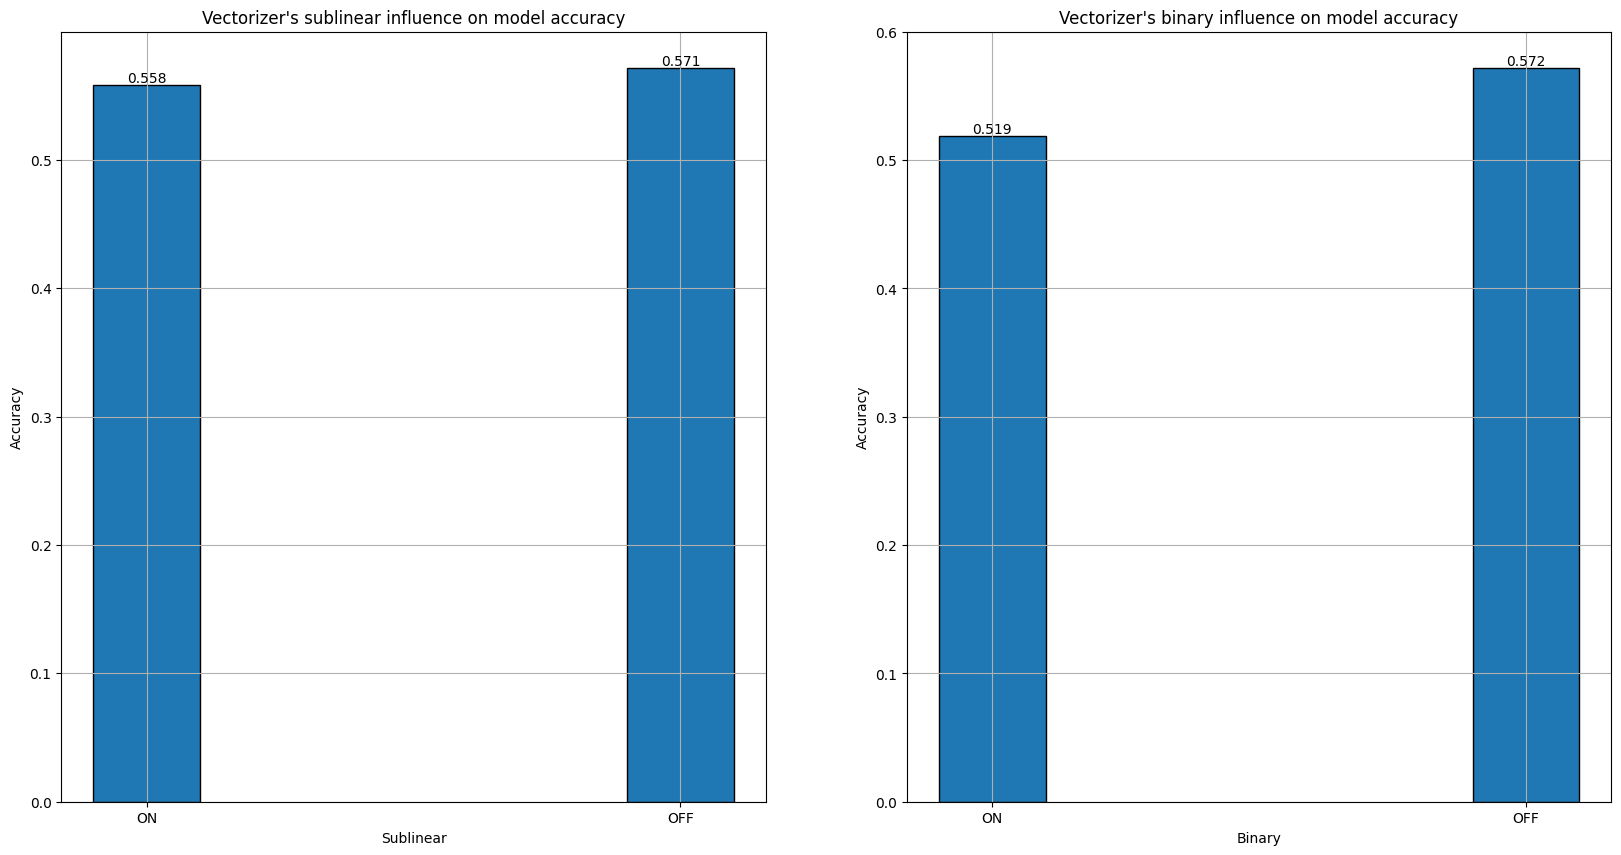

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Vectorizer's sublinear influence on model accuracy")
plt.xlabel("Sublinear")
plt.ylabel("Accuracy")
x_pos = range(len(SUBLINEAR_VALUES))
plt.bar(x_pos, sublinear_acc, width=0.2, edgecolor='black', tick_label=['ON', 'OFF'])
for i, acc in enumerate(sublinear_acc):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Vectorizer's binary influence on model accuracy")
plt.xlabel("Binary")
plt.ylabel("Accuracy")
x_pos = range(len(BINARY_VALUES))
plt.bar(x_pos, binary_acc, width=0.2, edgecolor='black', tick_label=['ON', 'OFF'])
for i, acc in enumerate(binary_acc):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)

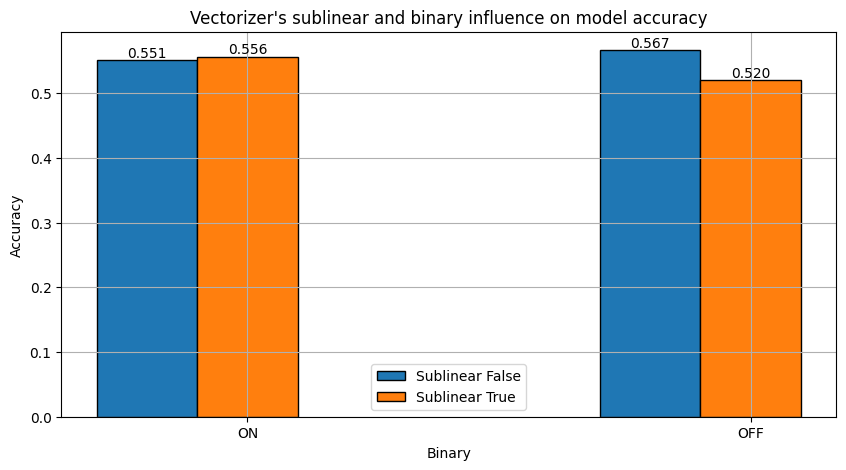

In [27]:
sublinear_false = combined_acc[False]
sublinear_true = combined_acc[True]
plt.figure(figsize=(10,5))
plt.title("Vectorizer's sublinear and binary influence on model accuracy")
plt.xlabel("Binary")
plt.ylabel("Accuracy")
x_pos = range(len(BINARY_VALUES))
plt.bar(x_pos, sublinear_false, width=0.2, edgecolor='black', tick_label=['ON', 'OFF'])
for i, acc in enumerate(sublinear_false):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.bar([i + 0.2 for i in x_pos], sublinear_true, width=0.2, edgecolor='black', tick_label=['ON', 'OFF'])
for i, acc in enumerate(sublinear_true):
    plt.text(x_pos[i] + 0.2, acc, f'{acc:.3f}', ha='center', va='bottom')
plt.legend(['Sublinear False', 'Sublinear True'])
plt.grid(True)

### Testowanie dla różnych wartości min_df i max_df

In [31]:
vocab_size = 15_000
n_gram = (1,2)
sublinear = False
binary = False
lowercase = True

min_max_df_acc = {}
index = 1
for min_df, max_df in MIN_MAX_DF:
    print(f"Training with min_df : {min_df} and max_df : {max_df} vocab_size : {vocab_size} ngram : {n_gram} | Training : [{index}/{len(MIN_MAX_DF)}]")
    index += 1

    vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=lowercase, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary, min_df=min_df, max_df=max_df)

    train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset) # getting input dimension for model (improvised)

    input_dim = train_idf.shape[1]

    model = SimpleNet(input_dim, n_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=15, verbose=False)

    min_max_df_acc[(min_df, max_df)] = accuracy


Training with min_df : 0.0 and max_df : 1.0 vocab_size : 15000 ngram : (1, 2) | Training : [1/7]


100%|██████████| 157/157 [00:02<00:00, 69.45it/s]


Training with min_df : 0.0 and max_df : 0.85 vocab_size : 15000 ngram : (1, 2) | Training : [2/7]


100%|██████████| 157/157 [00:01<00:00, 104.47it/s]


Training with min_df : 0.0 and max_df : 0.75 vocab_size : 15000 ngram : (1, 2) | Training : [3/7]


100%|██████████| 157/157 [00:01<00:00, 107.48it/s]


Training with min_df : 0.01 and max_df : 0.75 vocab_size : 15000 ngram : (1, 2) | Training : [4/7]


100%|██████████| 157/157 [00:00<00:00, 263.81it/s]


Training with min_df : 0.05 and max_df : 0.75 vocab_size : 15000 ngram : (1, 2) | Training : [5/7]


100%|██████████| 157/157 [00:00<00:00, 313.28it/s]


Training with min_df : 0.1 and max_df : 0.75 vocab_size : 15000 ngram : (1, 2) | Training : [6/7]


100%|██████████| 157/157 [00:00<00:00, 297.05it/s]


Training with min_df : 0.15 and max_df : 0.75 vocab_size : 15000 ngram : (1, 2) | Training : [7/7]


100%|██████████| 157/157 [00:00<00:00, 275.43it/s]


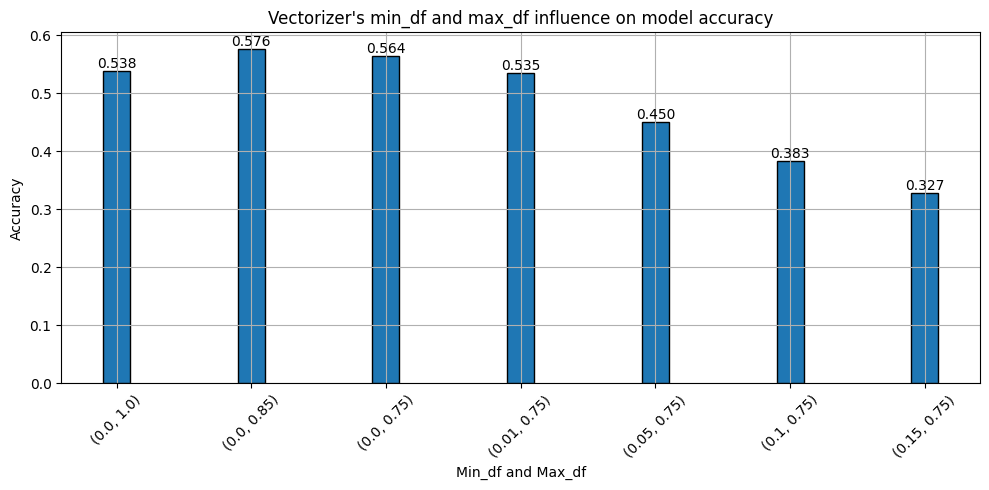

In [32]:
plt.figure(figsize=(10,5))
plt.title("Vectorizer's min_df and max_df influence on model accuracy")
plt.xlabel("Min_df and Max_df")
plt.ylabel("Accuracy")
x_pos = range(len(MIN_MAX_DF))
plt.bar(x_pos, min_max_df_acc.values(), width=0.2, edgecolor='black', tick_label=[str(i) for i in MIN_MAX_DF])
for i, acc in enumerate(min_max_df_acc.values()):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Testowanie norm l1 i l2

In [34]:
vocab_size = 15_000
n_gram = (1,2)
sublinear = False
binary = False
lowercase = True
min_df = 0.0
max_df = 0.85

norm_acc = {}

for norm in NORM:
    print(f"Training with norm : {norm}  vocab_size : {vocab_size} ngram : {n_gram}")

    vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=lowercase, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary, min_df=min_df, max_df=max_df, norm=norm)

    train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset) # getting input dimension for model (improvised)

    input_dim = train_idf.shape[1]

    model = SimpleNet(input_dim, n_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    accuracy = get_results_on_vectorizer(device, vectorizer, model, criterion, optimizer, lr_scheduler, epochs=15, verbose=False)

    norm_acc[norm] = accuracy

Training with norm : l1  vocab_size : 15000 ngram : (1, 2)


100%|██████████| 157/157 [00:02<00:00, 75.99it/s]


Training with norm : l2  vocab_size : 15000 ngram : (1, 2)


100%|██████████| 157/157 [00:01<00:00, 103.59it/s]


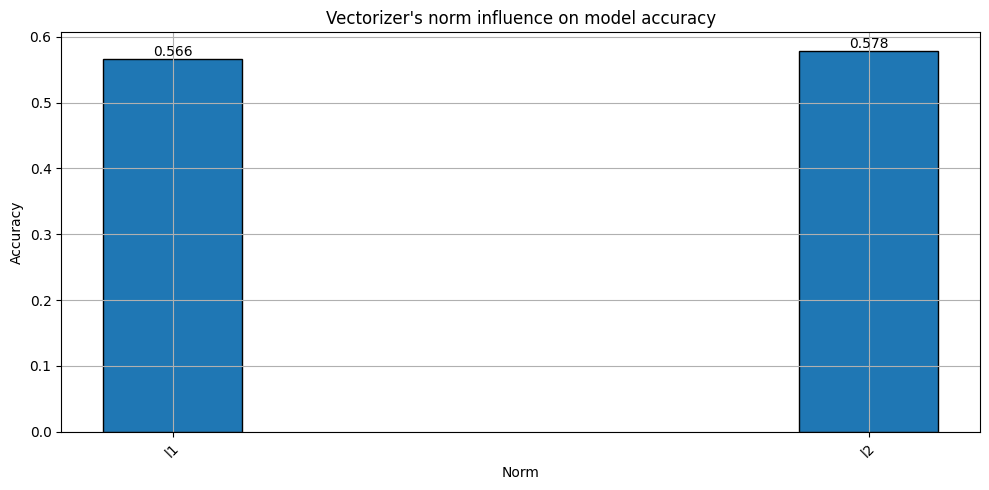

In [35]:
plt.figure(figsize=(10,5))
plt.title("Vectorizer's norm influence on model accuracy")
plt.xlabel("Norm")
plt.ylabel("Accuracy")
x_pos = range(len(NORM))
plt.bar(x_pos, norm_acc.values(), width=0.2, edgecolor='black', tick_label=NORM)
for i, acc in enumerate(norm_acc.values()):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Architektura modelu

### Jedna warstwa ukryta

In [36]:
class SingleLayer(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int, width: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.width = width

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, self.width),
            nn.LeakyReLU(),
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(width, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

#### Testowanie ilości neuronów ukrytych

In [37]:
vocab_size = 15_000
n_gram = (1,2)
sublinear = False
binary = False
lowercase = True
min_df = 0.0
max_df = 0.85
norm = 'l2'

widths = [8, 16, 32, 64, 128, 256, 512]
width_acc = {}

vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=lowercase, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary, min_df=min_df, max_df=max_df, norm=norm)

train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset)

input_dim = train_idf.shape[1]

tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

train_loader = create_dataloaders(tensor_train_dataset, 256, True)
val_loader = create_dataloaders(tensor_val_dataset, 256, False)
test_dataloader = create_dataloaders(tensor_test_dataset, 256, False)

dict_loaders = {'train' : train_loader,
                'val' : val_loader
                }


for width in widths:
    print(f"Training with width : {width}")
    model = SimpleNet(input_dim, n_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    train(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)
    report, accuracy = evaluate_model(device, model, test_dataloader)

    width_acc[width] = accuracy

Training with width : 8


100%|██████████| 79/79 [00:01<00:00, 50.53it/s]


Training with width : 16


100%|██████████| 79/79 [00:02<00:00, 33.56it/s]


Training with width : 32


100%|██████████| 79/79 [00:02<00:00, 38.92it/s]


Training with width : 64


100%|██████████| 79/79 [00:01<00:00, 48.97it/s]


Training with width : 128


100%|██████████| 79/79 [00:00<00:00, 80.61it/s]


Training with width : 256


100%|██████████| 79/79 [00:03<00:00, 20.81it/s]


Training with width : 512


100%|██████████| 79/79 [00:04<00:00, 17.11it/s]


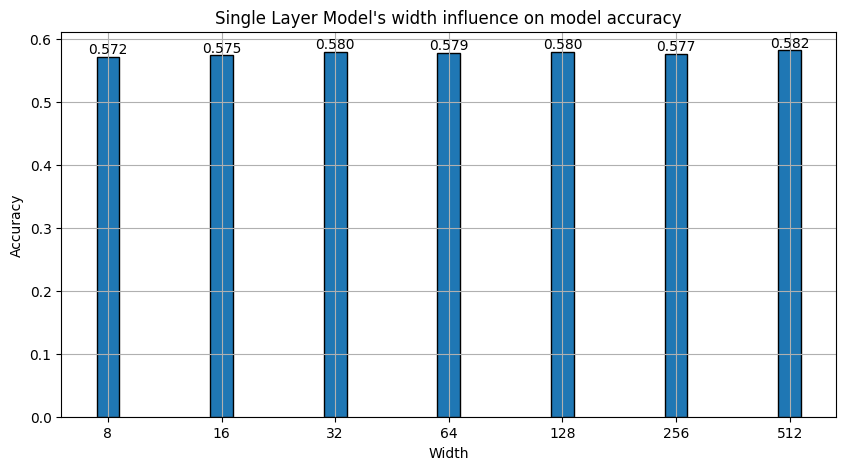

In [38]:
plt.figure(figsize=(10,5))
plt.title("Single Layer Model's width influence on model accuracy")
plt.xlabel("Width")
plt.ylabel("Accuracy")
x_pos = range(len(widths))
plt.bar(x_pos, width_acc.values(), width=0.2, edgecolor='black', tick_label=widths)
for i, acc in enumerate(width_acc.values()):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

### Dwie warstwy ukryte

In [39]:
class DoubleLayer(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int, width_1: int, width_2: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.width_1 = width_1
        self.width_2 = width_2

        self.dropout = nn.Dropout(0.1)

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, self.width_1),
            nn.LeakyReLU(),
            self.dropout,
            nn.Linear(self.width_1, self.width_2),
            nn.LeakyReLU(),
            self.dropout,
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(width_2, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.linear(features)
        return logits

In [47]:
vocab_size = 15_000
n_gram = (1,2)
sublinear = False
binary = False
lowercase = True
min_df = 0.0
max_df = 1.0
norm = 'l1'

widths = [(64, 64), (128, 128), (256, 256), (512, 512), (128, 64), (256, 128),(512, 256)]
width_acc_2_layers = {}

vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=lowercase, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary, min_df=min_df, max_df=max_df, norm=norm)

train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset)

input_dim = train_idf.shape[1]

tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

train_loader = create_dataloaders(tensor_train_dataset, 256, True)
val_loader = create_dataloaders(tensor_val_dataset, 256, False)
test_dataloader = create_dataloaders(tensor_test_dataset, 256, False)

dict_loaders = {'train' : train_loader,
                'val' : val_loader
                }


for width_1, width_2 in widths:
    print(f"Training with width_1 : {width_1} and width_2 : {width_2}")
    model = DoubleLayer(input_dim, n_classes=5, width_1=width_1, width_2=width_2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    train(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)
    report, accuracy = evaluate_model(device, model, test_dataloader)

    width_acc_2_layers[(width_1, width_2)] = accuracy

Training with width_1 : 64 and width_2 : 64


100%|██████████| 79/79 [00:01<00:00, 67.79it/s]


Training with width_1 : 128 and width_2 : 128


100%|██████████| 79/79 [00:00<00:00, 87.49it/s]


Training with width_1 : 256 and width_2 : 256


100%|██████████| 79/79 [00:01<00:00, 70.77it/s]


Training with width_1 : 512 and width_2 : 512


100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


Training with width_1 : 128 and width_2 : 64


100%|██████████| 79/79 [00:01<00:00, 67.19it/s]


Training with width_1 : 256 and width_2 : 128


100%|██████████| 79/79 [00:01<00:00, 67.57it/s]


Training with width_1 : 512 and width_2 : 256


100%|██████████| 79/79 [00:01<00:00, 65.44it/s]


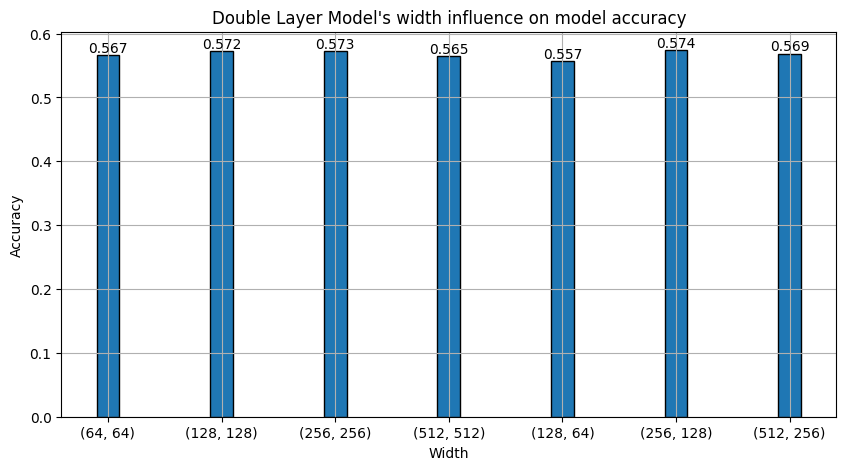

In [49]:
plt.figure(figsize=(10,5))
plt.title("Double Layer Model's width influence on model accuracy")
plt.xlabel("Width")
plt.ylabel("Accuracy")
x_pos = range(len(widths))
plt.bar(x_pos, width_acc_2_layers.values(), width=0.2, edgecolor='black', tick_label=[str(width) for width in widths])
for i, acc in enumerate(width_acc_2_layers.values()):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

## Hiperparametry uczenia

#### Funckja trenująca zapamiętujące wartości straty i loss'u

In [ ]:
def train_history(device, model: nn.Module, loaders: dict, criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, verbose: bool=True):
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "lr": []
    }

    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, target in tqdm(loaders[phase], desc=f"Epoch {epoch} {phase}"):
                X_batch, target = X_batch.to(device), target.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            epoch_loss = metric_loss.compute().item()
            epoch_acc = metric_acc.compute().item()
            current_lr = lr_scheduler.get_last_lr()[0]

            if verbose:
                print(f"(Epoch {epoch} - {phase}) Loss: {epoch_loss:.3f}   Accuracy: {epoch_acc:.3f}   lr: {current_lr}")

            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_accuracy"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_accuracy"].append(epoch_acc)
                history["lr"].append(current_lr)

            metric_loss.reset()
            metric_acc.reset()

        lr_scheduler.step()

    return history

### Model do testowania hiperparametrów

In [61]:
class HiperParametersModel(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int, width: int, dropout: float = 0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.width = width

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, self.width),
            nn.LeakyReLU(),
        )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(width, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

#### Inicjalzizacja zbiorów

In [59]:
vocab_size = 15_000
n_gram = (1,2)
sublinear = False
binary = False
lowercase = True
min_df = 0.0
max_df = 0.85
norm = 'l2'
width = 128

vectorizer = create_vectorizer(max_feature=vocab_size, lowercase=lowercase, ngram_range=n_gram, sublinear_tf=sublinear, binary=binary, min_df=min_df, max_df=max_df, norm=norm)

train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset)

input_dim = train_idf.shape[1]

tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

train_loader = create_dataloaders(tensor_train_dataset, 256, True)
val_loader = create_dataloaders(tensor_val_dataset, 256, False)
test_dataloader = create_dataloaders(tensor_test_dataset, 256, False)

dict_loaders = {'train' : train_loader,
                'val' : val_loader
                }

### Learning rate

In [ ]:
LR = [1e-4, 1e-3, 1e-2, 1e-1]
lr_values = {}
for lr in LR:
    print(f"Training with lr : {lr}")
    model = HiperParametersModel(input_dim, n_classes=5, width=width).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    history = train_history(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)

    lr_values[lr]  = history

Training with lr : 0.0001


Epoch 15 val: 100%|██████████| 40/40 [00:00<00:00, 45.29it/s]


Training with lr : 0.001


Epoch 15 val: 100%|██████████| 40/40 [00:00<00:00, 57.53it/s]


Training with lr : 0.01


Epoch 15 val: 100%|██████████| 40/40 [00:00<00:00, 60.09it/s]


Training with lr : 0.1


Epoch 15 val: 100%|██████████| 40/40 [00:00<00:00, 61.37it/s]


In [ ]:
for lr_key in lr_values:
    if 'lr' in lr_values[lr_key]:
        del lr_values[lr_key]['lr']

In [79]:
def plot__history(dict_values, hyperparameter_name):
    n_exp = len(dict_values)
    fig, axes = plt.subplots(n_exp, 2, figsize=(12, 4 * n_exp))
    for i, val in enumerate(sorted(dict_values)):
        history = dict_values[val]

        epochs = range(len(history['train_loss']))

        train_loss = [history['train_loss'][j] for j in epochs]
        val_loss = [history['val_loss'][j] for j in epochs]
        train_acc = [history['train_accuracy'][j] for j in epochs]
        val_acc = [history['val_accuracy'][j] for j in epochs]

        ax_loss = axes[i][0]
        ax_loss.plot(epochs, train_loss, marker='o', label='train_loss')
        ax_loss.plot(epochs, val_loss, marker='o', label='val_loss')
        ax_loss.set_title(f"{hyperparameter_name} = {val} | Loss")
        ax_loss.set_xlabel("Epoka")
        ax_loss.set_ylabel("Loss")
        ax_loss.grid(True)
        ax_loss.legend()

        ax_acc = axes[i][1]
        ax_acc.plot(epochs, train_acc, marker='o', label='train_accuracy')
        ax_acc.plot(epochs, val_acc, marker='o', label='val_accuracy')
        ax_acc.set_title(f"{hyperparameter_name} = {val} | Accuracy")
        ax_acc.set_xlabel("Epoka")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.grid(True)
        ax_acc.legend()

    fig.tight_layout()
    plt.show()


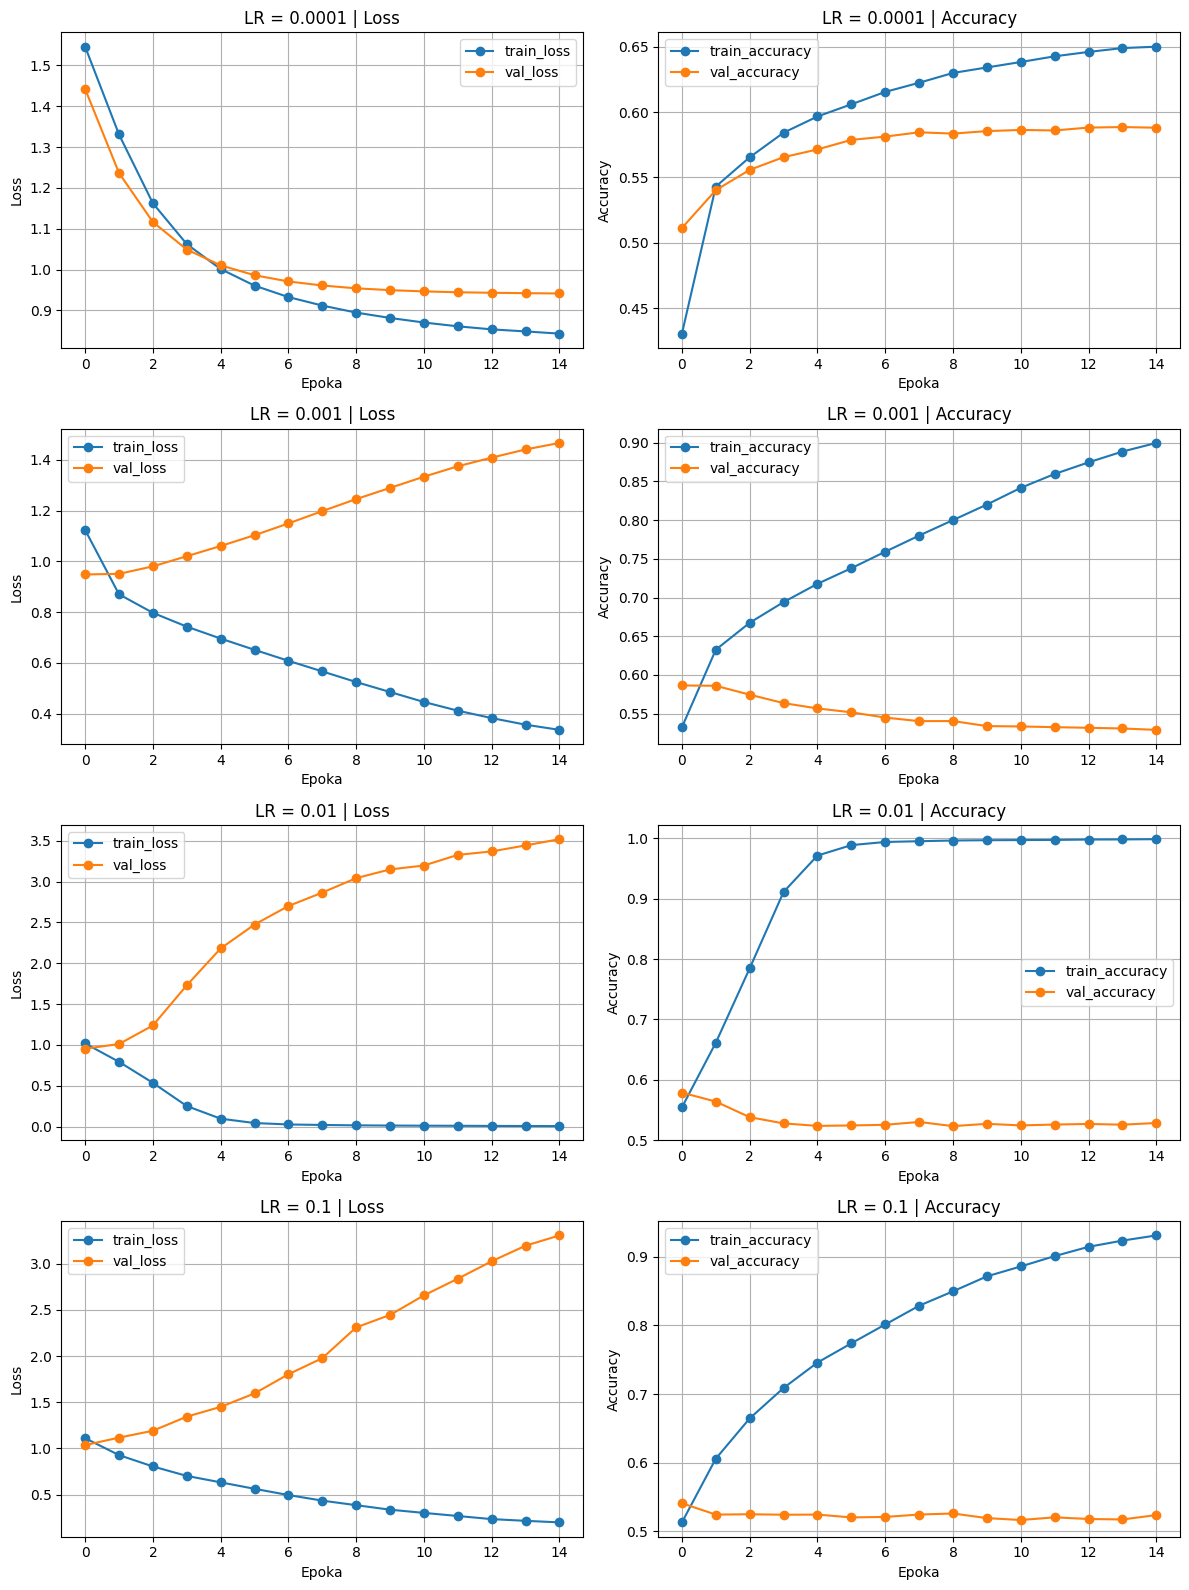

In [81]:
plot__history(lr_values, 'LR')

### Weight decay

In [72]:
WEIGHT_DECAY = [1e-5, 1e-4, 1e-3, 1e-2]
wd_values = {}
wd_acc = []
for wd in WEIGHT_DECAY:
    print(f"Training with weight decay : {wd}")
    model = HiperParametersModel(input_dim, n_classes=5, width=width).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=wd)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    history = train_history(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)

    wd_values[wd]  = history

    report, accuracy = evaluate_model(device, model, test_dataloader)
    wd_acc.append(accuracy)

Training with weight decay : 1e-05


100%|██████████| 79/79 [00:03<00:00, 20.08it/s]


Training with weight decay : 0.0001


100%|██████████| 79/79 [00:01<00:00, 63.13it/s]


Training with weight decay : 0.001


100%|██████████| 79/79 [00:00<00:00, 82.90it/s]


Training with weight decay : 0.01


100%|██████████| 79/79 [00:00<00:00, 83.44it/s]


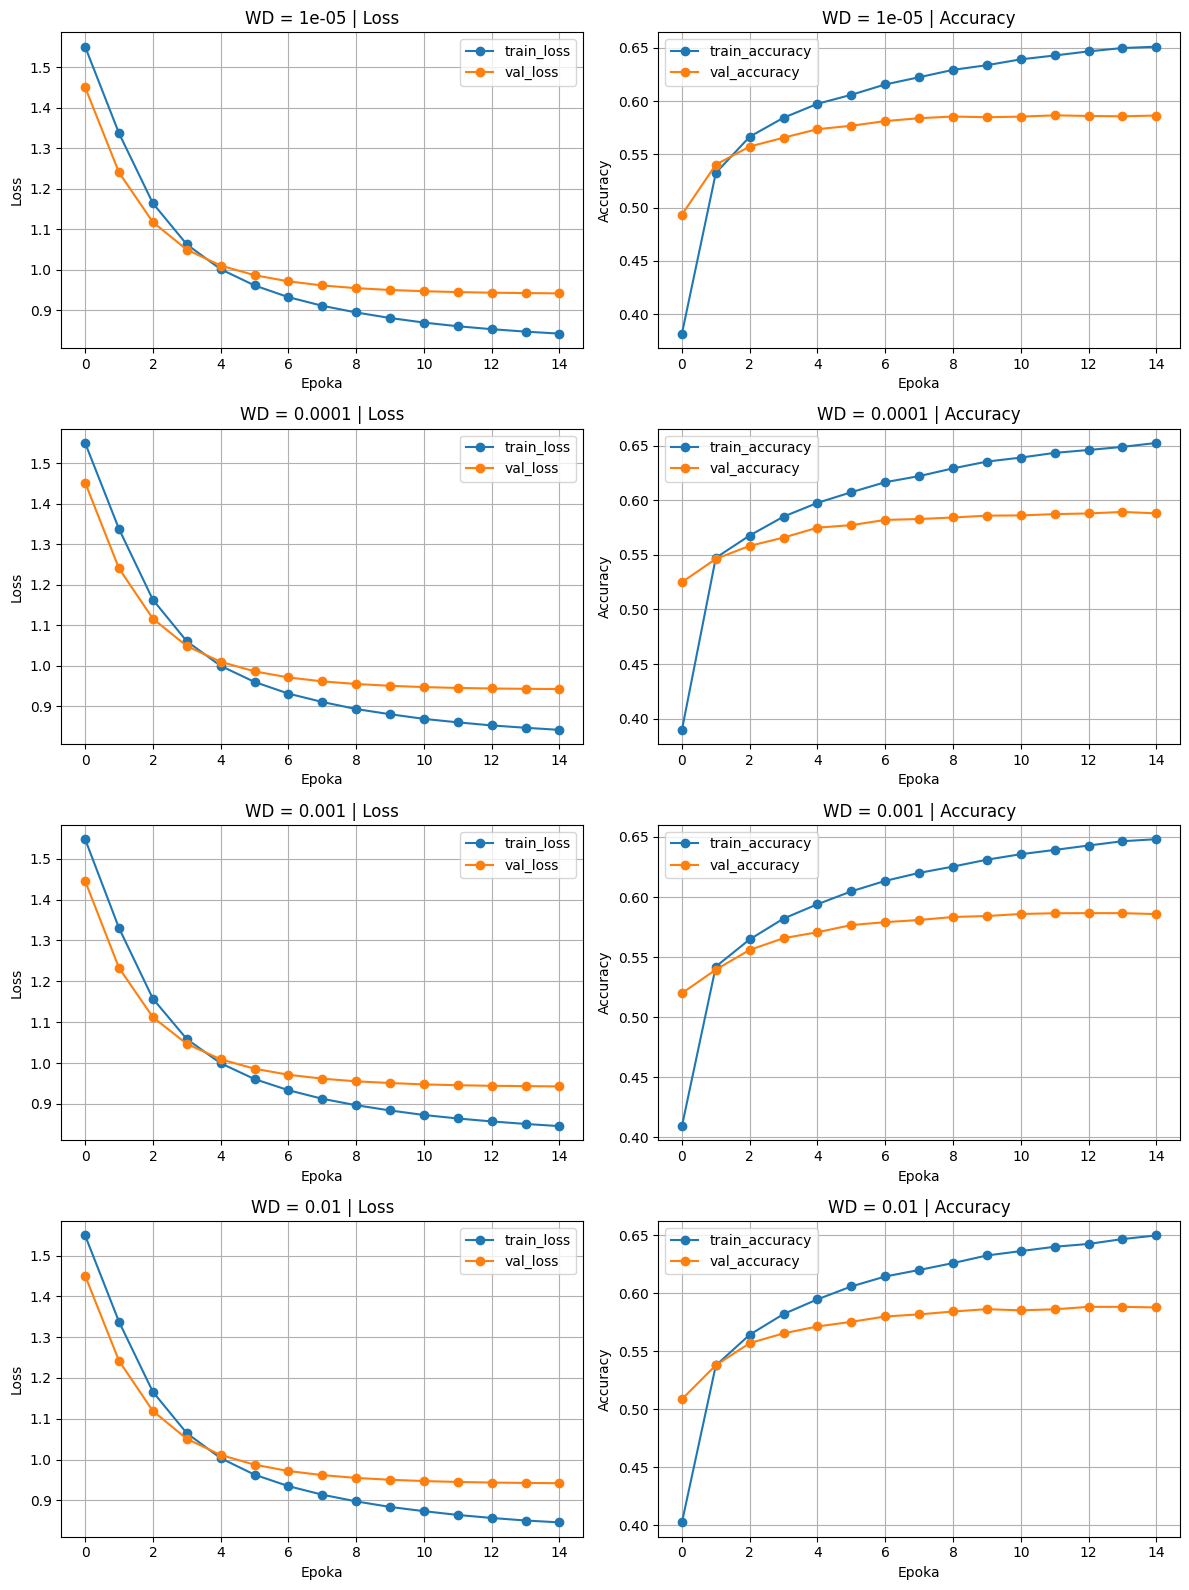

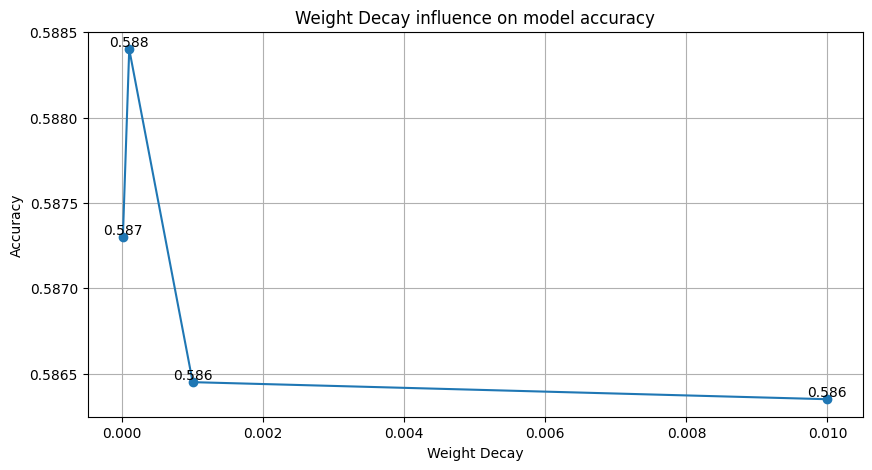

In [82]:
for wd_key in wd_values:
    if 'lr' in wd_values[wd_key]:
        del wd_values[wd_key]['lr']

plot__history(wd_values, 'WD')
plt.figure(figsize=(10,5))
plt.title("Weight Decay influence on model accuracy")
plt.xlabel("Weight Decay")
plt.ylabel("Accuracy")
plt.plot(WEIGHT_DECAY, wd_acc, marker='o', label='Accuracy')
for i, acc in enumerate(wd_acc):
    plt.text(WEIGHT_DECAY[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

### Dropout

In [77]:
DROPOUT = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_values = {}
dropout_acc = []

for dropout in DROPOUT:
    print(f"Training with dropout : {dropout}")
    model = HiperParametersModel(input_dim, n_classes=5, width=width, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    history = train_history(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)

    dropout_values[dropout]  = history

    report, accuracy = evaluate_model(device, model, test_dataloader)
    dropout_acc.append(accuracy)

Training with dropout : 0.1


100%|██████████| 79/79 [00:01<00:00, 44.51it/s]


Training with dropout : 0.2


100%|██████████| 79/79 [00:01<00:00, 74.58it/s]


Training with dropout : 0.3


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


Training with dropout : 0.4


100%|██████████| 79/79 [00:01<00:00, 72.20it/s]


Training with dropout : 0.5


100%|██████████| 79/79 [00:01<00:00, 77.58it/s]


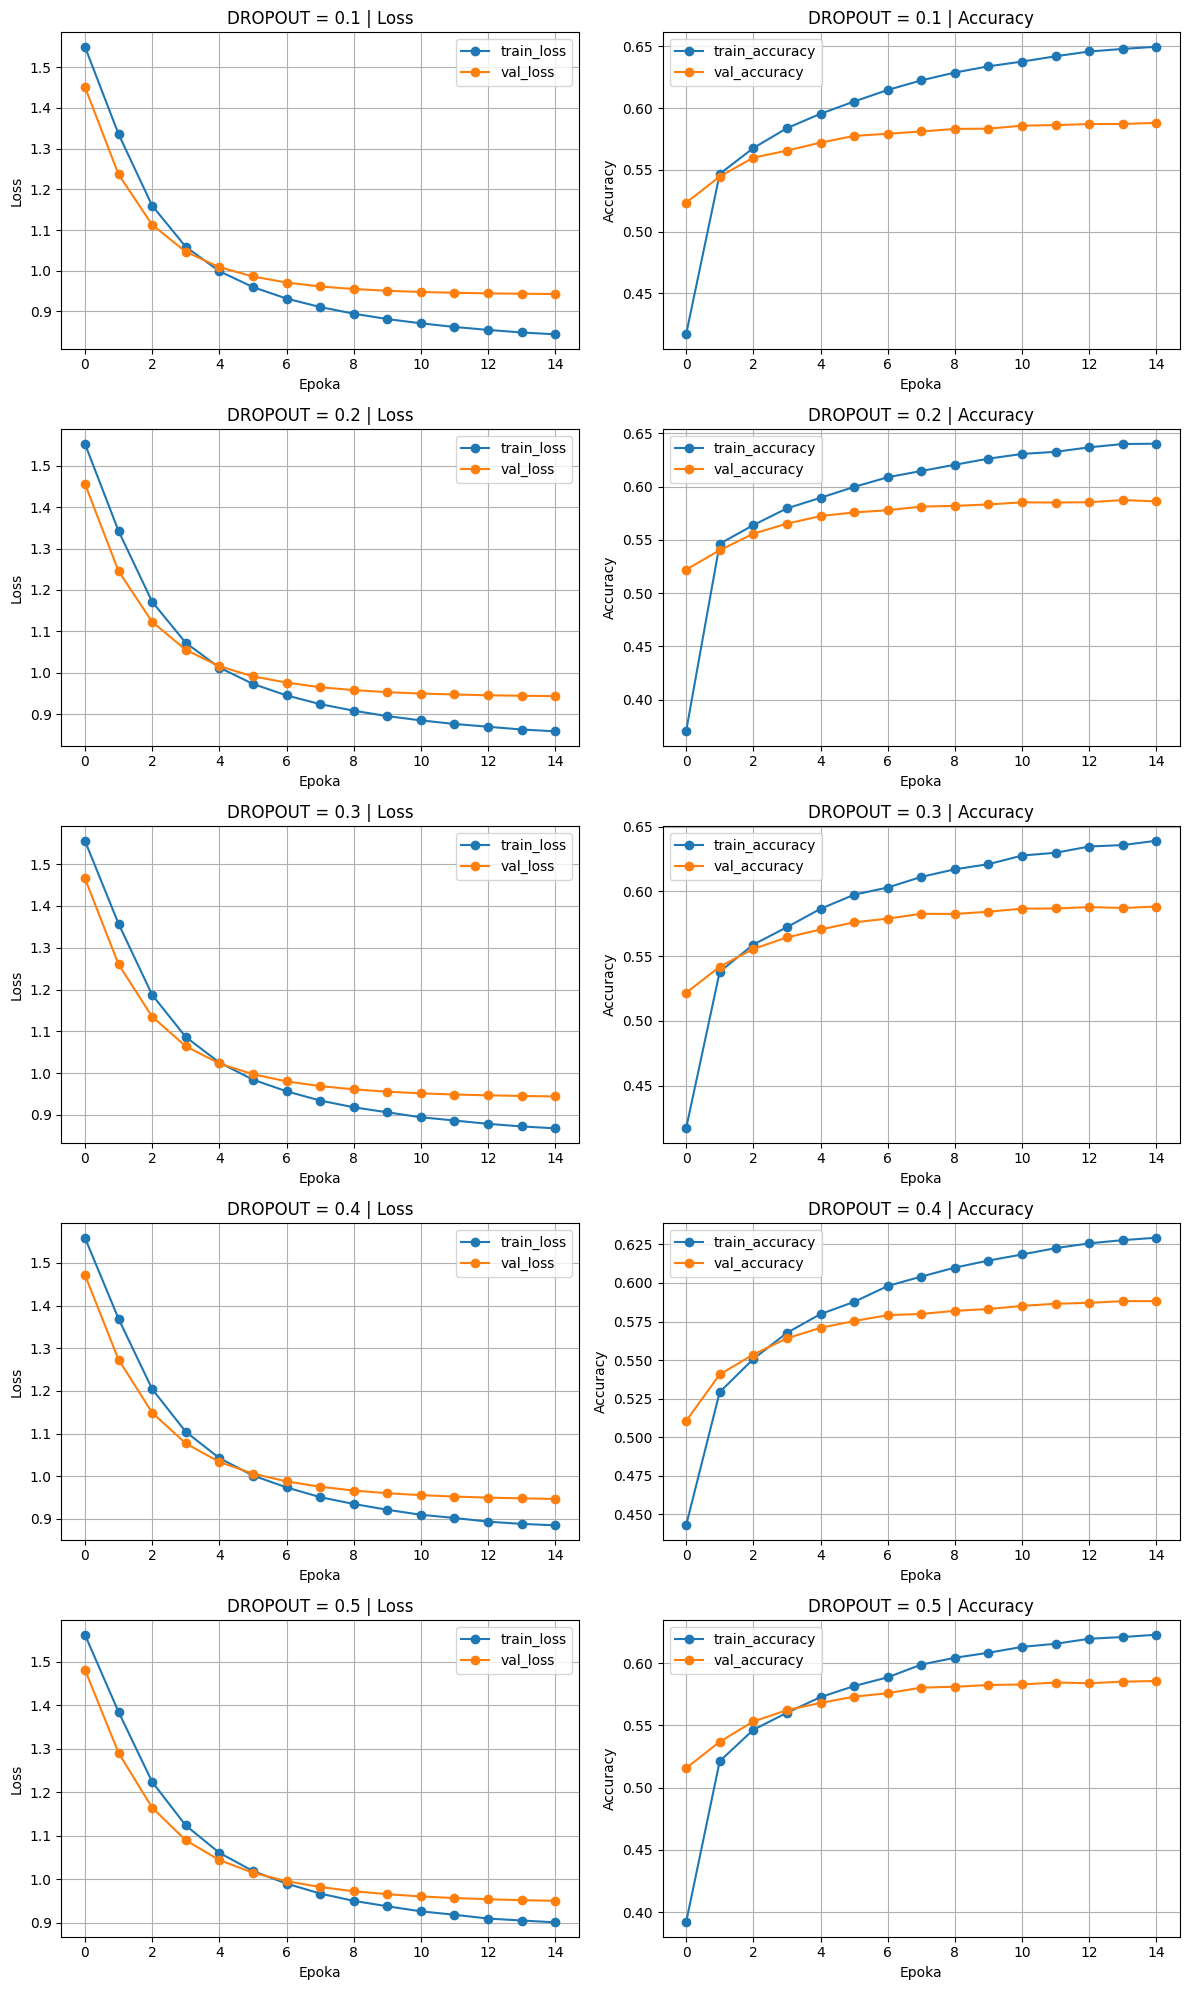

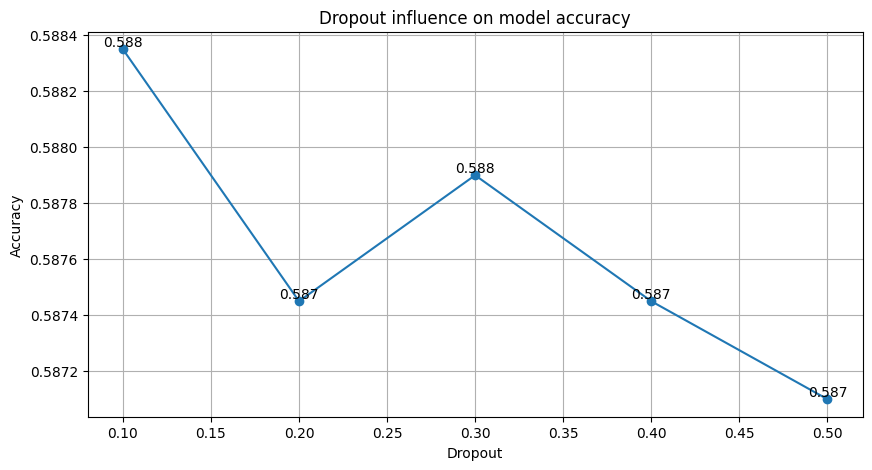

In [83]:
for dropout_key in dropout_values:
    if 'lr' in dropout_values[dropout_key]:
        del dropout_values[dropout_key]['lr']

plot__history(dropout_values, 'DROPOUT')

plt.figure(figsize=(10,5))
plt.title("Dropout influence on model accuracy")
plt.xlabel("Dropout")
plt.ylabel("Accuracy")
plt.plot(DROPOUT, dropout_acc, marker='o', label='Accuracy')
for i, acc in enumerate(dropout_acc):
    plt.text(DROPOUT[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

### Optimizer

In [84]:
optimizers ={
    'SGD' : torch.optim.SGD,
    'Adam' : torch.optim.Adam,
    'AdamW' : torch.optim.AdamW,
    'RMSprop' : torch.optim.RMSprop,
    'Adagrad' : torch.optim.Adagrad,
    'Adamax' : torch.optim.Adamax
}

optimizer_values = {}
optimizer_acc = []

for opt_name, opt in optimizers.items():
    print(f"Training with optimizer : {opt_name}")
    model = HiperParametersModel(input_dim, n_classes=5, width=width).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt(model.parameters(), lr=1e-4, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    history = train_history(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 15, verbose=False)

    optimizer_values[opt_name]  = history

    report, accuracy = evaluate_model(device, model, test_dataloader)
    optimizer_acc.append(accuracy)

Training with optimizer : SGD


100%|██████████| 79/79 [00:01<00:00, 63.77it/s]
c:\Users\barte\OneDrive\Pulpit\SEMESTR 6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\barte\OneDrive\Pulpit\SEMESTR 6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\barte\OneDrive\Pulpit\SEMESTR 6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Training with optimizer : Adam


100%|██████████| 79/79 [00:01<00:00, 71.24it/s]


Training with optimizer : AdamW


100%|██████████| 79/79 [00:01<00:00, 69.38it/s]


Training with optimizer : RMSprop


100%|██████████| 79/79 [00:01<00:00, 75.25it/s]


Training with optimizer : Adagrad


100%|██████████| 79/79 [00:01<00:00, 57.44it/s]


Training with optimizer : Adamax


100%|██████████| 79/79 [00:01<00:00, 61.48it/s]


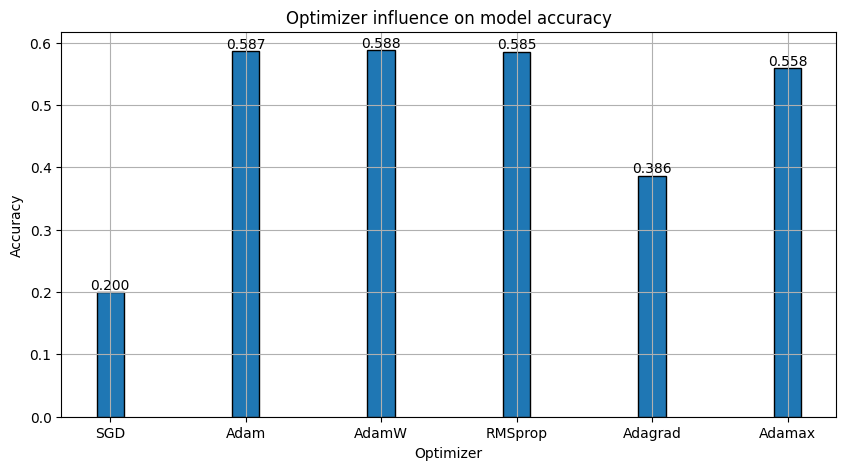

In [88]:
plt.figure(figsize=(10,5))
plt.title("Optimizer influence on model accuracy")
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
x_pos = range(len(optimizers))
plt.bar(x_pos, optimizer_acc, width=0.2, edgecolor='black', tick_label=list(optimizers.keys()))
for i, acc in enumerate(optimizer_acc):
    plt.text(x_pos[i], acc, f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True)
plt.show()

# Finalny model i predykcje

In [92]:
class FinalModel(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int, width: int, dropout: float = 0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.width = width

        self.dropout = nn.Dropout(dropout)

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, self.width),
            nn.LeakyReLU(),
            self.dropout,
        )
        self.linear = nn.Linear(width, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.linear(features)
        return logits

100%|██████████| 391/391 [00:10<00:00, 35.71it/s]


(Epoch 1/[train]) Loss:	1.547   Accuracy: 0.416   lr: 0.0001


100%|██████████| 40/40 [00:01<00:00, 36.88it/s]


(Epoch 1/[val]) Loss:	1.444   Accuracy: 0.517   lr: 0.0001


100%|██████████| 391/391 [00:07<00:00, 50.08it/s]


(Epoch 2/[train]) Loss:	1.330   Accuracy: 0.545   lr: 9.94459753267812e-05


100%|██████████| 40/40 [00:00<00:00, 57.65it/s]


(Epoch 2/[val]) Loss:	1.233   Accuracy: 0.541   lr: 9.94459753267812e-05


100%|██████████| 391/391 [00:07<00:00, 52.73it/s]


(Epoch 3/[train]) Loss:	1.158   Accuracy: 0.567   lr: 9.779754323328192e-05


100%|██████████| 40/40 [00:00<00:00, 56.90it/s]


(Epoch 3/[val]) Loss:	1.112   Accuracy: 0.556   lr: 9.779754323328192e-05


100%|██████████| 391/391 [00:06<00:00, 58.19it/s]


(Epoch 4/[train]) Loss:	1.059   Accuracy: 0.583   lr: 9.509529358847657e-05


100%|██████████| 40/40 [00:00<00:00, 65.70it/s]


(Epoch 4/[val]) Loss:	1.047   Accuracy: 0.566   lr: 9.509529358847657e-05


100%|██████████| 391/391 [00:07<00:00, 51.87it/s]


(Epoch 5/[train]) Loss:	1.000   Accuracy: 0.595   lr: 9.140576474687265e-05


100%|██████████| 40/40 [00:00<00:00, 50.40it/s]


(Epoch 5/[val]) Loss:	1.008   Accuracy: 0.573   lr: 9.140576474687265e-05


100%|██████████| 391/391 [00:07<00:00, 53.49it/s]


(Epoch 6/[train]) Loss:	0.960   Accuracy: 0.605   lr: 8.681980515339465e-05


100%|██████████| 40/40 [00:00<00:00, 60.87it/s]


(Epoch 6/[val]) Loss:	0.985   Accuracy: 0.577   lr: 8.681980515339465e-05


100%|██████████| 391/391 [00:06<00:00, 57.59it/s]


(Epoch 7/[train]) Loss:	0.932   Accuracy: 0.615   lr: 8.145033635316131e-05


100%|██████████| 40/40 [00:00<00:00, 65.51it/s]


(Epoch 7/[val]) Loss:	0.970   Accuracy: 0.581   lr: 8.145033635316131e-05


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


(Epoch 8/[train]) Loss:	0.911   Accuracy: 0.622   lr: 7.542957248827961e-05


100%|██████████| 40/40 [00:00<00:00, 55.39it/s]


(Epoch 8/[val]) Loss:	0.960   Accuracy: 0.583   lr: 7.542957248827961e-05


100%|██████████| 391/391 [00:06<00:00, 56.09it/s]


(Epoch 9/[train]) Loss:	0.895   Accuracy: 0.628   lr: 6.890576474687264e-05


100%|██████████| 40/40 [00:00<00:00, 52.88it/s]


(Epoch 9/[val]) Loss:	0.954   Accuracy: 0.585   lr: 6.890576474687264e-05


100%|██████████| 391/391 [00:07<00:00, 53.95it/s]


(Epoch 10/[train]) Loss:	0.881   Accuracy: 0.633   lr: 6.20395509268104e-05


100%|██████████| 40/40 [00:00<00:00, 56.38it/s]


(Epoch 10/[val]) Loss:	0.949   Accuracy: 0.586   lr: 6.20395509268104e-05


100%|██████████| 391/391 [00:07<00:00, 50.87it/s]


(Epoch 11/[train]) Loss:	0.870   Accuracy: 0.637   lr: 5.500000000000001e-05


100%|██████████| 40/40 [00:00<00:00, 62.54it/s]


(Epoch 11/[val]) Loss:	0.946   Accuracy: 0.588   lr: 5.500000000000001e-05


100%|██████████| 391/391 [00:07<00:00, 55.59it/s]


(Epoch 12/[train]) Loss:	0.862   Accuracy: 0.641   lr: 4.7960449073189627e-05


100%|██████████| 40/40 [00:00<00:00, 61.66it/s]


(Epoch 12/[val]) Loss:	0.944   Accuracy: 0.589   lr: 4.7960449073189627e-05


100%|██████████| 391/391 [00:07<00:00, 54.73it/s]


(Epoch 13/[train]) Loss:	0.854   Accuracy: 0.645   lr: 4.109423525312737e-05


100%|██████████| 40/40 [00:00<00:00, 52.26it/s]


(Epoch 13/[val]) Loss:	0.943   Accuracy: 0.589   lr: 4.109423525312737e-05


100%|██████████| 391/391 [00:07<00:00, 53.18it/s]


(Epoch 14/[train]) Loss:	0.848   Accuracy: 0.648   lr: 3.45704275117204e-05


100%|██████████| 40/40 [00:00<00:00, 67.16it/s]


(Epoch 14/[val]) Loss:	0.942   Accuracy: 0.588   lr: 3.45704275117204e-05


100%|██████████| 391/391 [00:06<00:00, 56.61it/s]


(Epoch 15/[train]) Loss:	0.843   Accuracy: 0.650   lr: 2.8549663646838717e-05


100%|██████████| 40/40 [00:00<00:00, 58.34it/s]


(Epoch 15/[val]) Loss:	0.941   Accuracy: 0.587   lr: 2.8549663646838717e-05


100%|██████████| 391/391 [00:07<00:00, 52.10it/s]


(Epoch 16/[train]) Loss:	0.839   Accuracy: 0.652   lr: 2.3180194846605367e-05


100%|██████████| 40/40 [00:00<00:00, 54.76it/s]


(Epoch 16/[val]) Loss:	0.941   Accuracy: 0.588   lr: 2.3180194846605367e-05


100%|██████████| 391/391 [00:06<00:00, 56.23it/s]


(Epoch 17/[train]) Loss:	0.836   Accuracy: 0.655   lr: 1.859423525312737e-05


100%|██████████| 40/40 [00:00<00:00, 57.57it/s]


(Epoch 17/[val]) Loss:	0.940   Accuracy: 0.589   lr: 1.859423525312737e-05


100%|██████████| 391/391 [00:06<00:00, 57.30it/s]


(Epoch 18/[train]) Loss:	0.834   Accuracy: 0.654   lr: 1.490470641152345e-05


100%|██████████| 40/40 [00:00<00:00, 56.38it/s]


(Epoch 18/[val]) Loss:	0.940   Accuracy: 0.588   lr: 1.490470641152345e-05


100%|██████████| 391/391 [00:06<00:00, 58.89it/s]


(Epoch 19/[train]) Loss:	0.832   Accuracy: 0.656   lr: 1.2202456766718093e-05


100%|██████████| 40/40 [00:00<00:00, 51.03it/s]


(Epoch 19/[val]) Loss:	0.940   Accuracy: 0.589   lr: 1.2202456766718093e-05


100%|██████████| 391/391 [00:07<00:00, 55.58it/s]


(Epoch 20/[train]) Loss:	0.831   Accuracy: 0.655   lr: 1.0554024673218807e-05


100%|██████████| 40/40 [00:00<00:00, 56.86it/s]


(Epoch 20/[val]) Loss:	0.940   Accuracy: 0.588   lr: 1.0554024673218807e-05


100%|██████████| 79/79 [00:01<00:00, 68.96it/s]


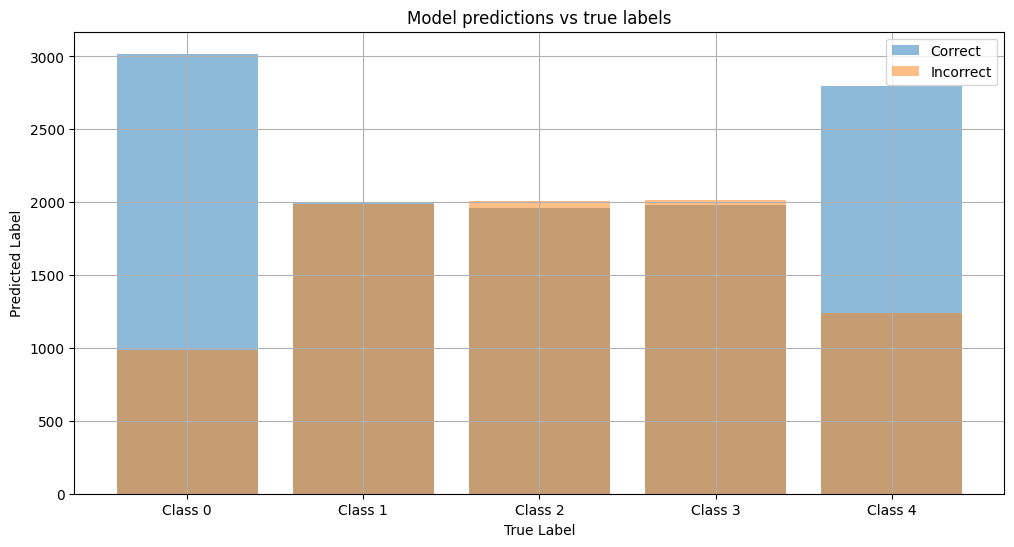

In [ ]:

train_idf, val_idf, test_idf = create_tfidf_features(vectorizer, train_dataset, val_dataset, test_dataset)
input_dim = train_idf.shape[1]

tensor_train_dataset = create_tensor_dataset(train_idf, train_dataset['label'])
tensor_val_dataset = create_tensor_dataset(val_idf, val_dataset['label'])
tensor_test_dataset = create_tensor_dataset(test_idf, test_dataset['label'])

train_loader = create_dataloaders(tensor_train_dataset, 256, True)
val_loader = create_dataloaders(tensor_val_dataset, 256, False)
test_dataloader = create_dataloaders(tensor_test_dataset, 256, False)

dict_loaders = {'train' : train_loader,
                'val' : val_loader
                }


model = FinalModel(vocab_size=input_dim, n_classes=5, width=128, dropout=0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

train(device, model, dict_loaders, criterion, optimizer, lr_scheduler, 20, verbose=True)



num_classes = 5

results_by_class = {i: {"correct": [], "incorrect": []} for i in range(num_classes)}

with torch.no_grad():
    model.eval()
    for X_batch, target in tqdm(test_dataloader):
        X_batch, target = X_batch.to(device), target.to(device)
        logits = model(X_batch)
        _, preds = torch.max(logits, dim=1)

        for t, p in zip(target.cpu().numpy(), preds.cpu().numpy()):
            if t == p:
                results_by_class[t]["correct"].append(p)
            else:
                results_by_class[t]["incorrect"].append(p)

plt.figure(figsize=(12, 6))
plt.title("Model predictions vs true labels")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.bar(range(num_classes), [len(results_by_class[i]["correct"]) for i in range(num_classes)], label='Correct', alpha=0.5)
plt.bar(range(num_classes), [len(results_by_class[i]["incorrect"]) for i in range(num_classes)], label='Incorrect', alpha=0.5)
plt.xticks(range(num_classes), [f'Class {i}' for i in range(num_classes)])
plt.legend()
plt.grid(True)
plt.show()